### Background Project

In this “getting started” competition, you’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer

**Evaluation**

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]
where:

𝑛
 is the total number of instances,
𝑦̂ 𝑖
 is the predicted value of the target for instance (i),
𝑦𝑖
 is the actual value of the target for instance (i), and,
log
 is the natural logarithm.

### Import Libraries

In [1917]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

import datetime as dt
from datetime import datetime as dt

import warnings
import missingno as msno

In [1918]:
from scipy.stats import pearsonr

In [1919]:
seed = 42

sns.set_style('darkgrid')
sns.set_palette('RdBu')


In [1920]:
warnings.filterwarnings('ignore')

In [1921]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

### Utils

In [1922]:
def index_date(data):
    data["date"] = pd.to_datetime(data["date"])
    data.set_index(data["date"], inplace=True)
    data.drop("date", axis=1, inplace=True)


### Load datset

#### Read the data

In [1923]:
train = pd.read_csv("dataset/train.csv")

In [1924]:
dataset = ["train", "test", "oil", "holidays_events", "stores", "transactions"]

In [1925]:
for data in dataset:
    print(data)
    exec("{} = pd.read_csv('dataset/{}.csv')".format(data, data))

train


test
oil
holidays_events
stores
transactions


##### train data

In [1926]:
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE   0.00            0
1   1  2013-01-01          1   BABY CARE   0.00            0
2   2  2013-01-01          1      BEAUTY   0.00            0
3   3  2013-01-01          1   BEVERAGES   0.00            0
4   4  2013-01-01          1       BOOKS   0.00            0

In [1927]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


##### transactioin data

In [1928]:
transactions.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [1929]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


##### stores data

In [1930]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [1931]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


##### oil data

In [1932]:
oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [1933]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


#####  holidays_events data

In [1934]:
holidays_events.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [1935]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


### EDA

#### Cleaning The data

based on the process above we can also see if there is missing data in the dataset

##### oil data

we need to check if there is no missing days in the some dataset like train, oil, and transactions dataset.


In [1936]:
oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [1937]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

<AxesSubplot: >

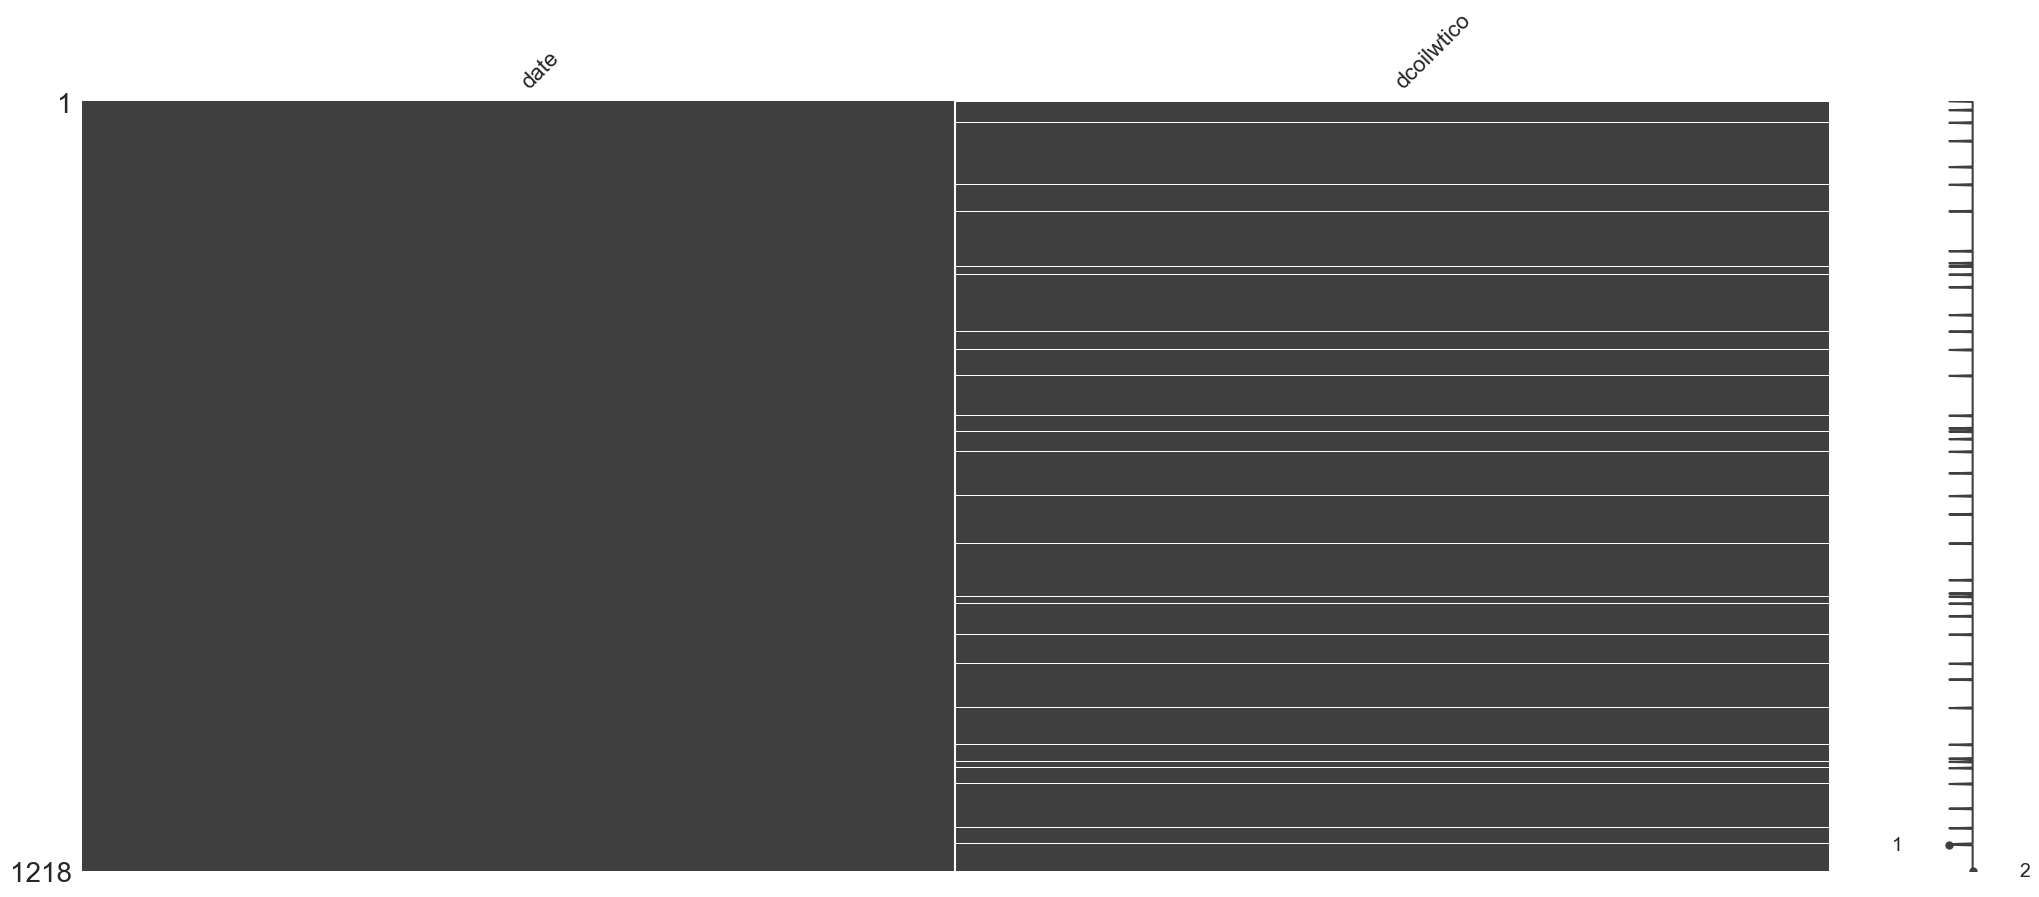

In [1938]:
msno.matrix(oil)

In [1939]:
index_date(oil)

<AxesSubplot: xlabel='date'>

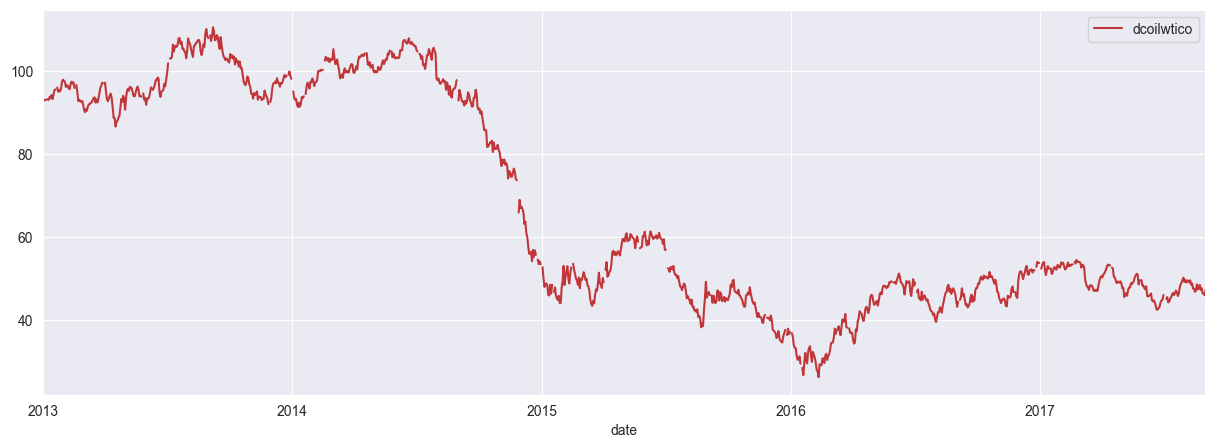

In [1940]:
oil.plot(figsize=(15, 5))

based on visuzalization above we are gonna use linear method to fill the missing values

In [1941]:
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(method="linear")

In [1942]:
oil.loc["2013-01-01", "dcoilwtico"] = 93.14

In [1943]:
oil["year"] = oil.index.year
oil["month"] = oil.index.month
oil["day"] = oil.index.day
oil["weekday"] = oil.index.weekday

checking missing days

In [1944]:
missing_days = pd.date_range(start='2013-01-01', end='2017-08-15').difference(oil.index)
missing_days

DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-15', '2017-07-16', '2017-07-22', '2017-07-23',
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', length=482, freq=None)

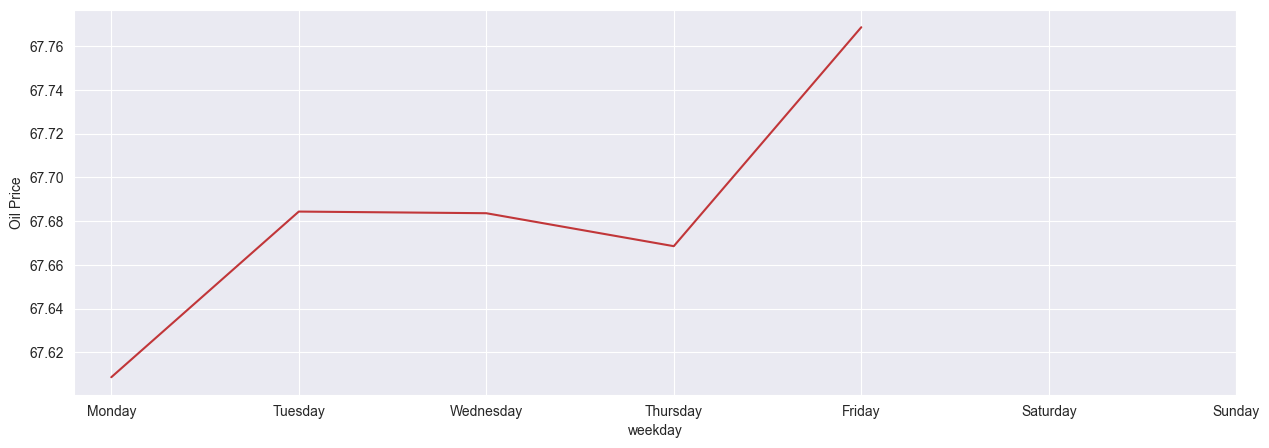

In [1945]:
oil.groupby("weekday")["dcoilwtico"].mean().plot(figsize=(15, 5))

plt.xticks(np.arange(7), weekday_order)
plt.ylabel("Oil Price")
plt.show()

as we know if trading oil is closed on weekends, so we fill the missing using beased on the last price on that weekend or forward fill

In [1946]:

# solve the error by adding the missing days, i want to add directly to as index
oil = oil.append(pd.DataFrame(index=missing_days))



In [1947]:
oil.sort_index(inplace=True)

In [1948]:
oil["year"] = oil.index.year
oil["month"] = oil.index.month
oil["day"] = oil.index.day
oil["weekday"] = oil.index.weekday

In [1949]:
oil.fillna(method="ffill", inplace=True)

#### Train data

In [1950]:
index_date(train)

In [1951]:
train["year"] = train.index.year
train["month"] = train.index.month
train["weekday"] = train.index.weekday
train["day"] = train.index.day

In [1952]:
train["weekday"] = train["weekday"].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})

we drop 2017 data  in eda process because it is only until december so it will not bias our agregation

In [1953]:
train_viz = train.loc[train["year"] != 2017]

In [1954]:
min_date = train_viz.index.min()
max_date = train_viz.index.max()

In [1955]:
pd.date_range(start=min_date, end=max_date).difference(train_viz.index)

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

there are missing days train dataset, we will see later for the result what should we do when doing forecasting

we have those missing date or days in train date 

In [1956]:
train.isna().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
weekday        0
day            0
dtype: int64

In [1957]:
train.duplicated().sum()

0

#### test data

 move the next dataset "test" to do checkinngs and cleaning

In [1958]:
test.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [1959]:
index_date(test)

In [1960]:
test.isna().sum()

id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [1961]:
test.duplicated().sum()

0

we dont have missing days in test data

In [1962]:
len(test.index.unique())

16

#### holidays_events data

In [1963]:
holidays_events["type"].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [1964]:
holidays_events["locale"].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

In [1965]:
holidays_events["date"].min(), holidays_events["date"].max()

('2012-03-02', '2017-12-26')

we need to drop some data like 2017 and 2012 data

In [1966]:
# we drop the transferred holidays

holidays = holidays_events[holidays_events["transferred"] == False]
holidays = holidays[(holidays["date"] < "2017-01-01") & (holidays["date"] >= "2013-01-01")]


In [1967]:
holidays.head()

date      type    locale locale_name  \
41  2013-01-01   Holiday  National     Ecuador   
42  2013-01-05  Work Day  National     Ecuador   
43  2013-01-12  Work Day  National     Ecuador   
44  2013-02-11   Holiday  National     Ecuador   
45  2013-02-12   Holiday  National     Ecuador   

                           description  transferred  
41                  Primer dia del ano        False  
42             Recupero puente Navidad        False  
43  Recupero puente primer dia del ano        False  
44                            Carnaval        False  
45                            Carnaval        False

In [1968]:
index_date(holidays)

In [1969]:
holidays.loc[holidays.index.duplicated(keep=False)].tail()

type    locale locale_name                      description  \
date                                                                            
2016-07-24    Transfer     Local   Guayaquil  Traslado Fundacion de Guayaquil   
2016-11-12     Holiday     Local      Ambato          Independencia de Ambato   
2016-11-12    Work Day  National     Ecuador  Recupero Puente Dia de Difuntos   
2016-12-22  Additional  National     Ecuador                        Navidad-3   
2016-12-22     Holiday     Local     Salinas         Cantonizacion de Salinas   

            transferred  
date                     
2016-07-24        False  
2016-11-12        False  
2016-11-12        False  
2016-12-22        False  
2016-12-22        False

if you check there are some date that have 2 holidays in a day like national and local. So we need to drop the local one because already included in national

In [1970]:
holidays["year"] = holidays.index.year
holidays["month"] = holidays.index.month
holidays["weekday"] = holidays.index.weekday
holidays["day"] = holidays.index.day



In [1971]:
holidays.drop_duplicates(subset=["locale", "locale_name", "year", "month", "day"], inplace=True)


In [1972]:
filtered_index = holidays[(holidays.index.duplicated(keep=False)) & (holidays["locale"] == "National")].index

holidays_filtered = holidays.drop(holidays[(holidays.index.isin(filtered_index)) & ((holidays["locale"] == "Local") | (holidays["locale"] == "Regional"))].index)


In [1973]:
holidays_filtered["weekday"] = holidays_filtered["weekday"].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})

In [1974]:
###this datasset will be used to help in forecasting the sales
holidays_events.drop_duplicates(subset=["date","locale", "locale_name"], inplace=True)

index_date(holidays_events)

filtered_index = holidays_events[(holidays_events.index.duplicated(keep=False)) & (holidays_events["locale"] == "National")].index

holidays_events_filtered = holidays_events.drop(holidays_events[(holidays_events.index.isin(filtered_index)) & ((holidays_events["locale"] == "Local") | (holidays_events["locale"] == "Regional"))].index)

national_holidays = holidays_events_filtered[holidays_events_filtered["locale"] == "National"]

holidays_events_filtered["national"] = holidays_events_filtered.index.isin(national_holidays.index)

#### transactionas data

In [838]:
index_date(transactions)

In [1131]:
transactions.index.min(), transactions.index.max()

(0, 83487)

Data trainsaction is from 2013-01-01 to 2017-08-15 and test is from 2017-08-16 to 2017-08-31. It means we cannot use transactions data for training. we can use  only for EDA.

In [1132]:
pd.date_range(start="2013-01-01", end="2017-08-15").difference(transactions.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

same with the train data if there are some missing days in the transactions

In [1133]:
transactions["year"] = transactions.index.year
transactions["month"] = transactions.index.month
transactions["day"] = transactions.index.day
transactions["weekday"] = transactions.index.weekday

AttributeError: 'RangeIndex' object has no attribute 'year'

In [1134]:
transactions_viz = transactions.loc[transactions["year"] != 2017]

KeyError: 'year'

Note :
* Transaction is the number of transaction in each store
* Sales is the total sales in each store especially is some category family in train dataset

#### Analysis Data

##### Distribution of stores

In [1135]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [1136]:
stores.shape

(54, 5)

In [1137]:
print(f'there are {stores["cluster"].nunique()} clusters')

there are 17 clusters


In [1138]:
stores["type"].value_counts().sort_index()

A     9
B     8
C    15
D    18
E     4
Name: type, dtype: int64

In [1139]:
stores["state"].value_counts().sort_index()

Azuay                              3
Bolivar                            1
Chimborazo                         1
Cotopaxi                           2
El Oro                             2
Esmeraldas                         1
Guayas                            11
Imbabura                           1
Loja                               1
Los Rios                           2
Manabi                             3
Pastaza                            1
Pichincha                         19
Santa Elena                        1
Santo Domingo de los Tsachilas     3
Tungurahua                         2
Name: state, dtype: int64

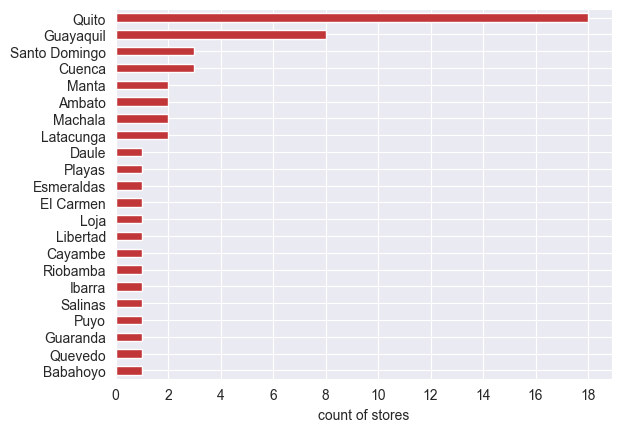

In [1140]:

stores["city"].value_counts().sort_values().plot(kind='barh')


plt.xticks(np.arange(0, 20, 2))
plt.xlabel("count of stores")

plt.show()

**Key points :**

1. There are 54 stores, 22 cities, 16 states, 5 types, 17 clusters
2. 18 of 54 stores (33%) are in Quito city or capital city of Ecuador

#### Analysis by time

**Combine Dataset and Feature Engineering**

we will have two important dataset. First is transactions and stores

In [1141]:
transactions_viz.head()

store_nbr  transactions  year  month  day  weekday
date                                                          
2013-01-01         25           770  2013      1    1        1
2013-01-02          1          2111  2013      1    2        2
2013-01-02          2          2358  2013      1    2        2
2013-01-02          3          3487  2013      1    2        2
2013-01-02          4          1922  2013      1    2        2

In [1142]:
transactions_store= transactions_viz.merge(stores, on="store_nbr", how="left")

In [1143]:
transactions_store.set_index(transactions_viz.index, inplace=True)

In [1144]:
sales_store = train_viz.groupby(["date","store_nbr" ])["sales", "onpromotion"].sum().reset_index()

In [1145]:
transaction_full= transactions_store.merge(sales_store, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left")

In [1146]:
transaction_full.set_index("date", inplace=True)

aov(average order values)

aov  = sales/transactions

In [1147]:
transaction_full["aov"] = transaction_full["sales"] / transaction_full["transactions"]

promotional_sales_ratio (psr) = promotional_sales(onpromotion) / total_sales

In [1148]:
# promotional_sales_ratio (psr)= promotional_sales(onpromotion) / total_sales

transaction_full["psr"] = transaction_full["onpromotion"] / transaction_full["sales"]

add holidays data

In [1149]:
local_holidays = holidays_filtered[holidays_filtered["locale"] == "Local"]
regional_holidays = holidays_filtered[holidays_filtered["locale"] == "Regional"]
national_holidays = holidays_filtered[holidays_filtered["locale"] == "National"]

In [1150]:
def is_holiday_local(row):
    dummy = local_holidays[['year', 'month', 'day', 'locale_name']]
    if row[['year', 'month', 'day', 'city']].isin(dummy).all():
        return 1
    else:
        return 0

In [1151]:
def is_holiday_regional(row):
    dummy = regional_holidays[['year', 'month', 'day', 'locale_name']]
    if row[['year', 'month', 'day', 'state']].isin(dummy).all():
        return 1
    else:
        return 0

In [1152]:
transaction_full["local_holiday"] = transaction_full.apply(is_holiday_local, axis=1)
transaction_full["regional_holiday"] = transaction_full.apply(is_holiday_regional, axis=1)

In [1153]:
transaction_full["national_holiday"] = transaction_full.index.isin(national_holidays.index)

In [1154]:
transaction_full["total_holiday"] = transaction_full["local_holiday"] + transaction_full["regional_holiday"] + transaction_full["national_holiday"]

Add oil price

In [1155]:
transaction_full = transaction_full.merge(oil[["dcoilwtico"]], left_index=True, right_index=True, how="left")

#### Analysis year and month 

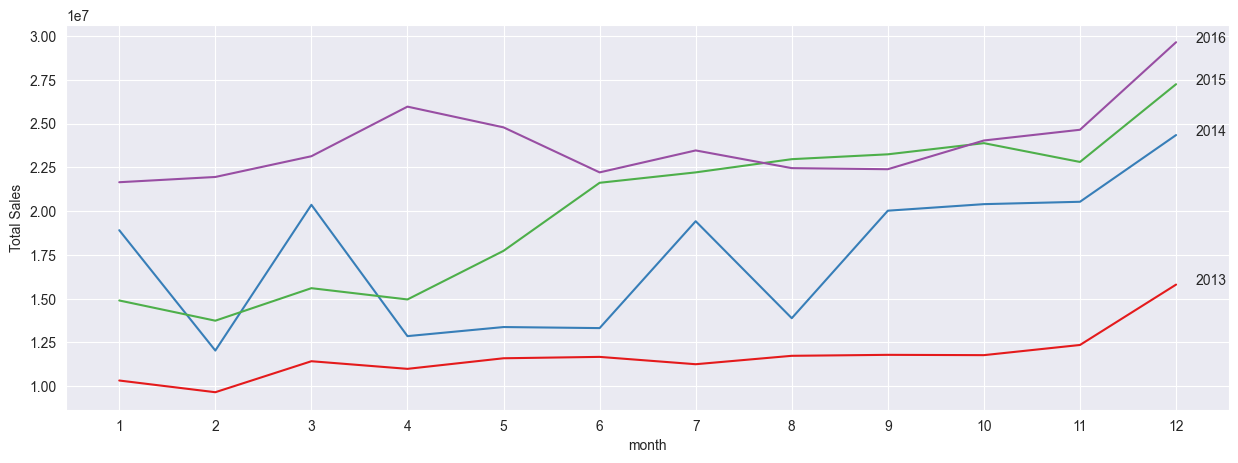

In [1156]:
year = transaction_full.groupby(["year","month"])["sales"].sum().reset_index()


plt.figure(figsize=(15, 5))
sns.lineplot(x="month", y="sales", hue="year", data=year, palette="Set1", legend = False)


for year_value in year["year"].unique():
    subset = year[year["year"] == year_value]
    last_point = subset.tail(1)
    plt.annotate(year_value, xy=(last_point["month"].values[0], last_point["sales"].values[0]),
                 xytext=(last_point["month"].values[0] + 0.2, last_point["sales"].values[0]))


plt.xticks(np.arange(1, 13))
plt.ylabel("Total Sales")


plt.show()

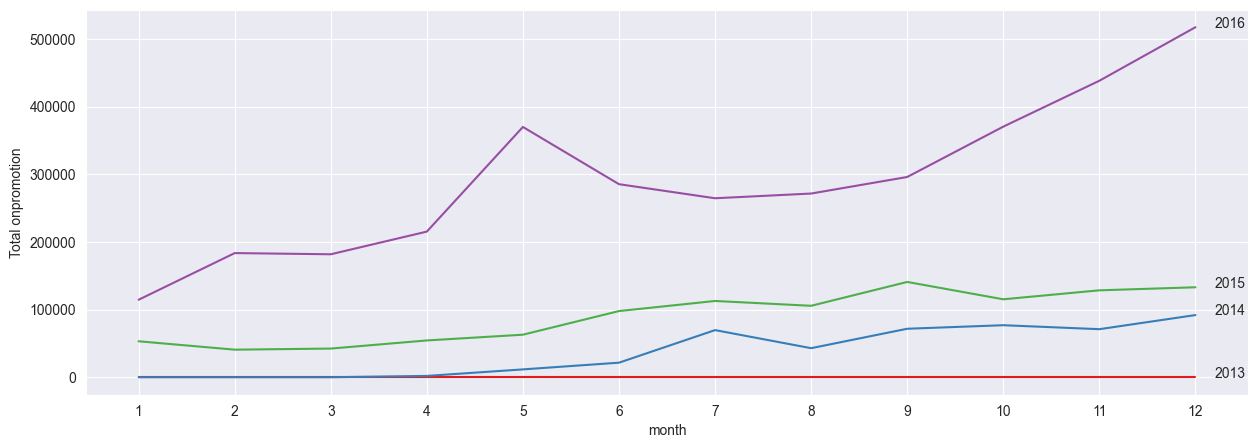

In [1157]:
year = transaction_full.groupby(["year","month"])["onpromotion"].sum().reset_index()


plt.figure(figsize=(15, 5))
sns.lineplot(x="month", y="onpromotion", hue="year", data=year, palette="Set1", legend = False)


for year_value in year["year"].unique():
    subset = year[year["year"] == year_value]
    last_point = subset.tail(1)
    plt.annotate(year_value, xy=(last_point["month"].values[0], last_point["onpromotion"].values[0]),
                 xytext=(last_point["month"].values[0] + 0.2, last_point["onpromotion"].values[0]))


plt.xticks(np.arange(1, 13))
plt.ylabel("Total onpromotion")


plt.show()

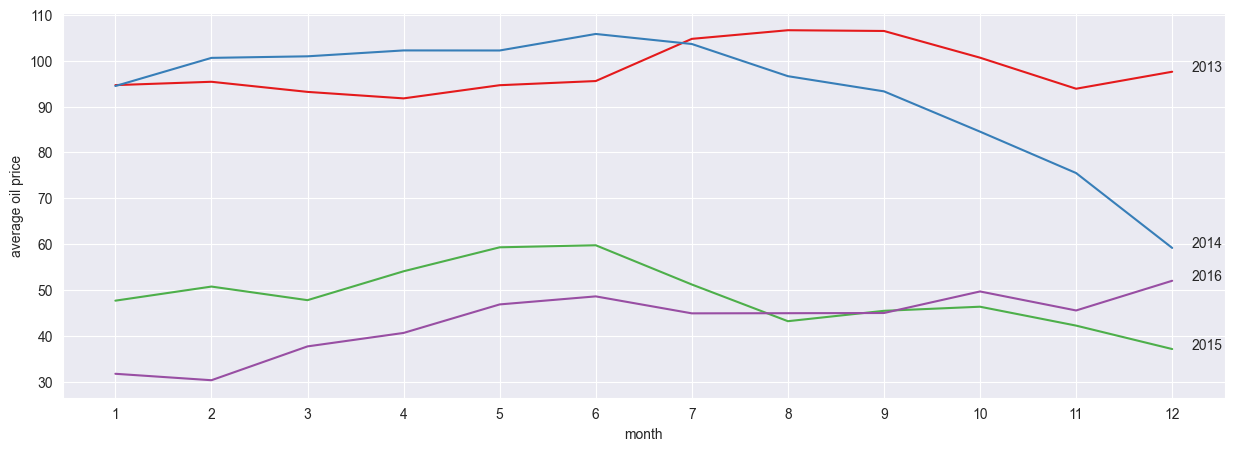

In [1158]:
year = transaction_full.groupby(["year","month"])["dcoilwtico"].mean().reset_index()


plt.figure(figsize=(15, 5))
sns.lineplot(x="month", y="dcoilwtico", hue="year", data=year, palette="Set1", legend = False)


for year_value in year["year"].unique():
    subset = year[year["year"] == year_value]
    last_point = subset.tail(1)
    plt.annotate(year_value, xy=(last_point["month"].values[0], last_point["dcoilwtico"].values[0]),
                 xytext=(last_point["month"].values[0] + 0.2, last_point["dcoilwtico"].values[0]))


plt.xticks(np.arange(1, 13))
plt.ylabel("average oil price")


plt.show()

**key points:**

1. the isteresting point from the graph above is that the sales and onpromotion are increasing every year, but the oil price has lower in 2015 and 2016 than 2013 and 2014.
2. the isterestin point is how the sales in 2015 is increased but in 2016 is is decreased after earthquake in april 2016. but the onpromotion is increased to make keep the sales in 2016.

##### Analysis by Year

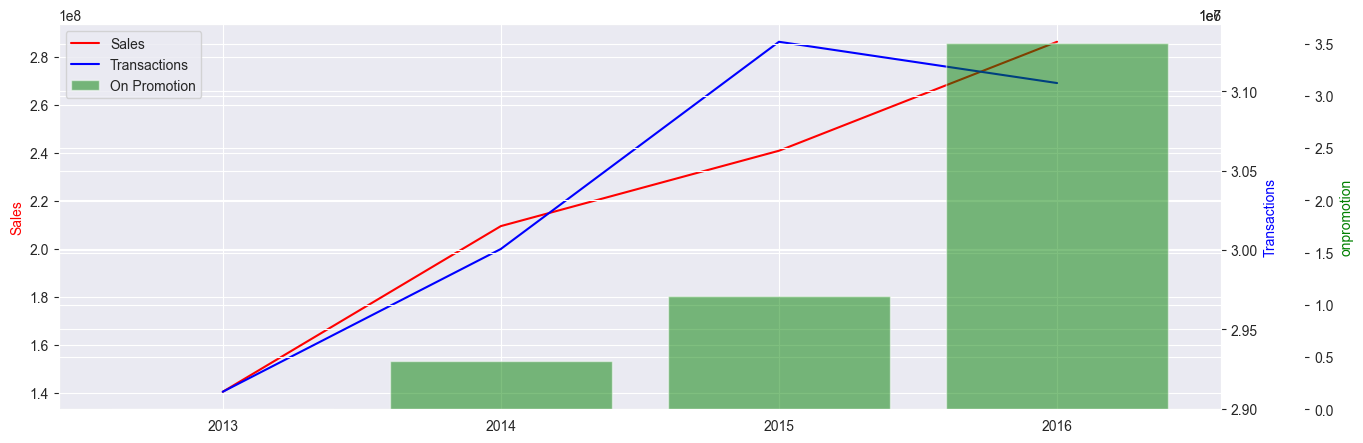

In [1159]:
fig, ax1 = plt.subplots(figsize=(15, 5))

ax2 = ax1.twinx()

ax1.plot(transaction_full.groupby("year")["sales"].sum(), color="red", label="Sales")
ax2.plot(transaction_full.groupby("year")["transactions"].sum(), color="blue", label="Transactions")

ax1.set_ylabel('Sales', color="red")
ax2.set_ylabel('Transactions', color="blue")

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

ax3.bar(transaction_full.groupby("year")["onpromotion"].sum().index, transaction_full.groupby("year")["onpromotion"].sum(), color="green", alpha=0.5, label="On Promotion")
ax3.set_ylabel('onpromotion', color="green")

plt.xticks(np.arange(2013, 2017, 1))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
plt.legend(lines + lines2 + lines3, labels + labels2 + labels3)

plt.xlabel("Year")

plt.show()


**key points:**

1. Number of transaction and sales is increasing every year except number of transaction in 2016 is decreasing. Earthquake in 2016 can give impact to economic in Ecuador. "In 2016, GDP fell by 1.5% —after weak growth of 0.2% in 2015".
(src : "https://repositorio.cepal.org/server/api/core/bitstreams/0af21473-4631-463e-aea0-9665f3673828/content"
2. Even though number of transaction is decreasing in 2016, sales is increasing. This can be due to number of onpromotion is highly increasing in 2016 around 222% from 2015
3. This sales also can be affected by oil price, which every year oil price is decreasing that can affect the customer purchasing power

In [1160]:
### Table percentage of change in on promotion each year

promotion = transaction_full.groupby("year")["onpromotion"].sum().reset_index().sort_values("year")
promotion["percentage_change"] = promotion["onpromotion"].pct_change()*100

In [1161]:
promotion

year  onpromotion  percentage_change
0  2013            0                NaN
1  2014       459114                inf
2  2015      1087275         136.820267
3  2016      3509267         222.757996

**oil price**

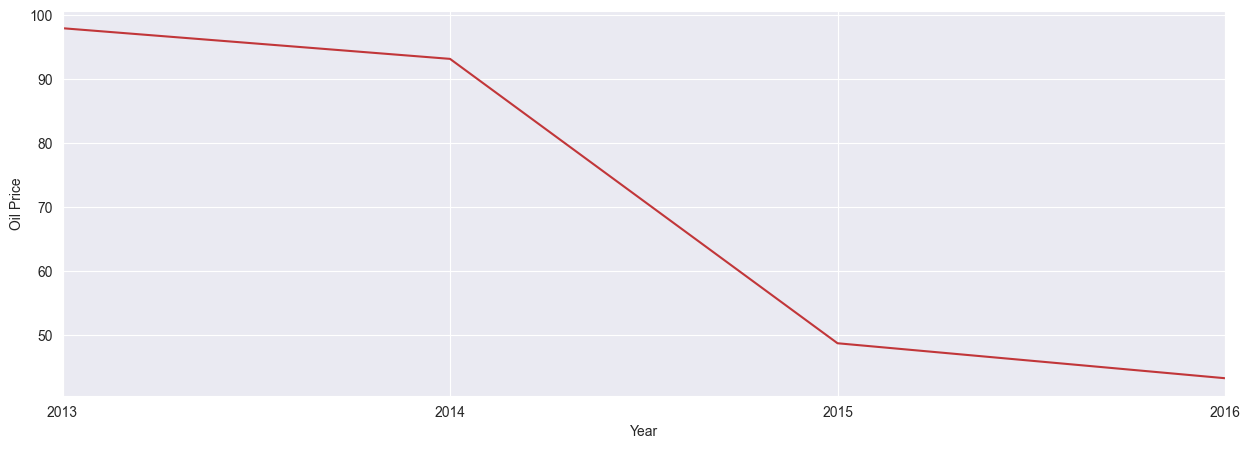

In [1162]:
oil.groupby("year")["dcoilwtico"].mean().plot(kind="line", figsize=(15, 5))

plt.xticks(np.arange(2013, 2017, 1))

plt.xlabel("Year")
plt.ylabel("Oil Price")

plt.xlim(2013, 2016)

plt.show()

**holidays**

In [1163]:
holidays_filtered["national_holiday"] = holidays_filtered["locale"].apply(lambda x: 1 if x == "National" else 0)

Text(0, 0.5, 'Number of National Holiday')

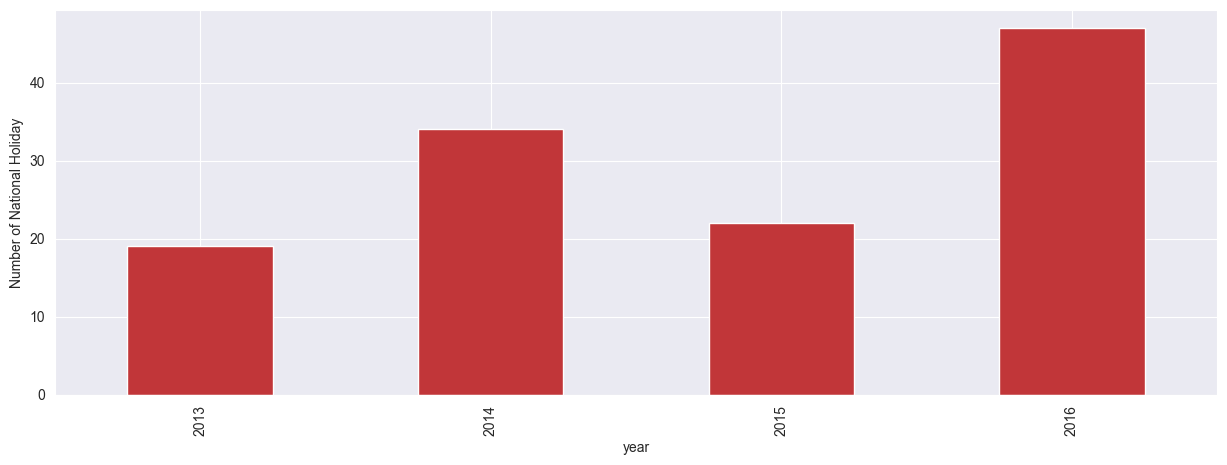

In [1164]:
holidays_filtered.groupby("year")["national_holiday"].sum().plot(kind="bar", figsize=(15, 5))

plt.ylabel("Number of National Holiday")

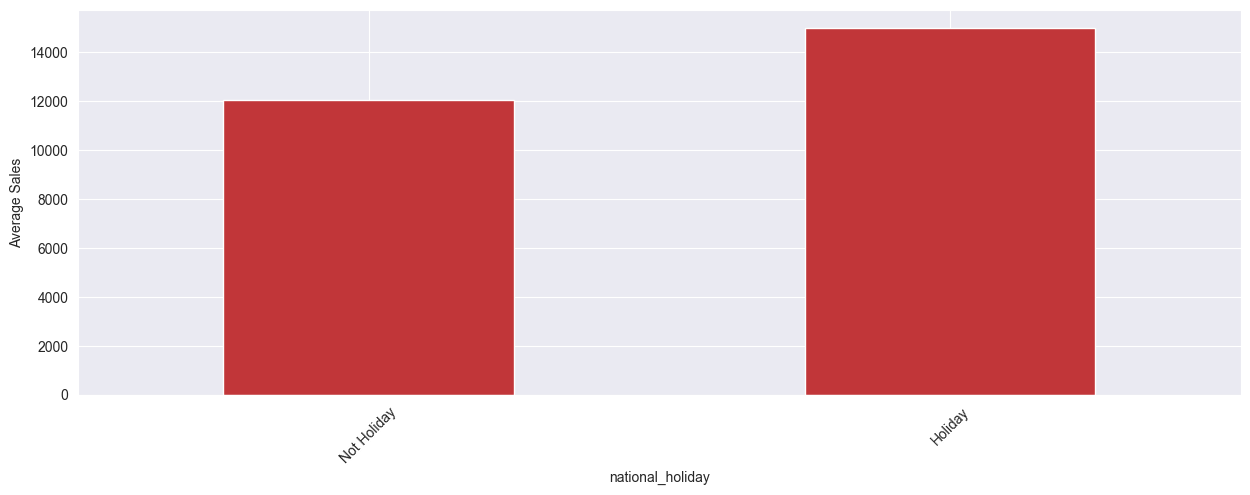

In [1165]:
transaction_full.groupby("national_holiday")["sales"].mean().plot(kind="bar", figsize=(15, 5))

plt.xticks(np.arange(0, 2), ["Not Holiday", "Holiday"], rotation=45)
plt.ylabel("Average Sales")

plt.show()

**key points :**

1. Number of holidays in 214 is increasing because of the World Cup 2014 in Brazil. Then in 2016 because of equador earthquake.
2. Average sales in holidays is higher than not holidays
3. if we see in 2015 number of holidays is decreasing but the average sales is increasing. Maybe because of the number of promotion is increasing 136%

#### Analysis by Month

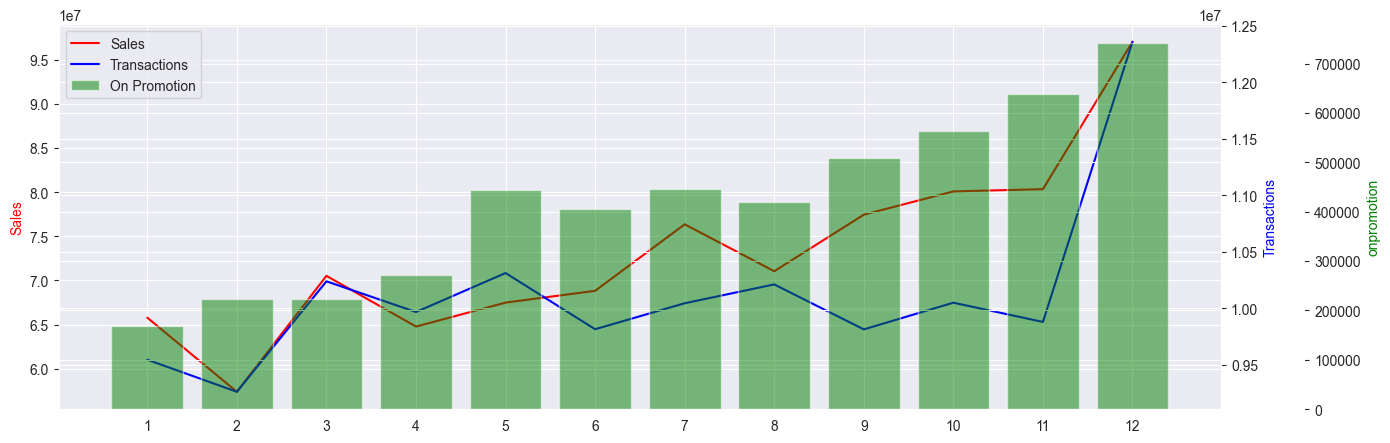

In [1166]:
fig, ax1 = plt.subplots(figsize=(15, 5))

ax2 = ax1.twinx()

ax1.plot(transaction_full.groupby("month")["sales"].sum(), color="red", label="Sales")
ax2.plot(transaction_full.groupby("month")["transactions"].sum(), color="blue", label="Transactions")

ax1.set_ylabel('Sales', color="red")
ax2.set_ylabel('Transactions', color="blue")

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

ax3.bar(transaction_full.groupby("month")["onpromotion"].sum().index, transaction_full.groupby("month")["onpromotion"].sum(), color="green", alpha=0.5, label="On Promotion")
ax3.set_ylabel('onpromotion', color="green")

plt.xticks(np.arange(1,13, 1))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
plt.legend(lines + lines2 + lines3, labels + labels2 + labels3)

plt.xlabel("month")

plt.show()


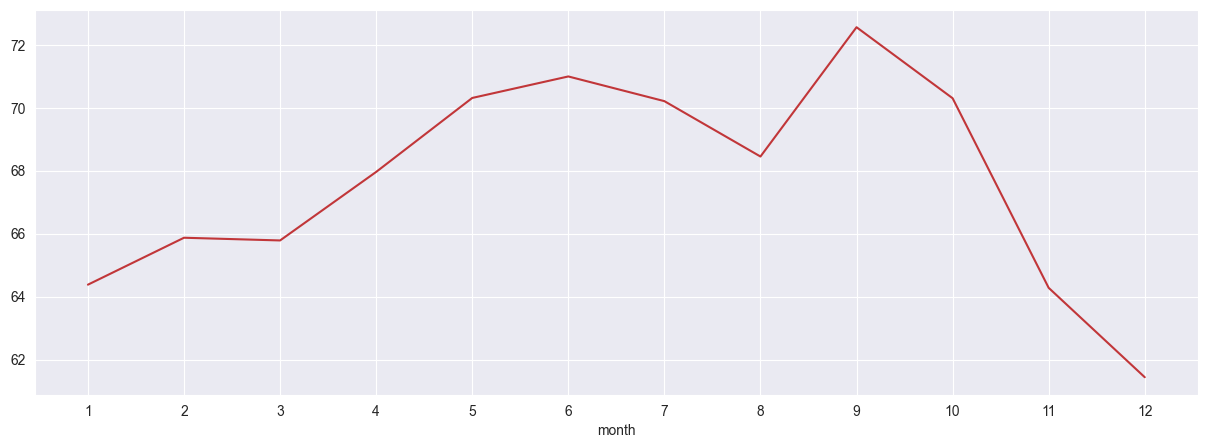

In [1167]:
oil.groupby("month")["dcoilwtico"].mean().plot(kind="line", figsize=(15, 5))

plt.xticks(np.arange(1, 13))

plt.show()

In [1168]:
month = transaction_full.groupby(["year", "month"])["sales"].sum().reset_index()

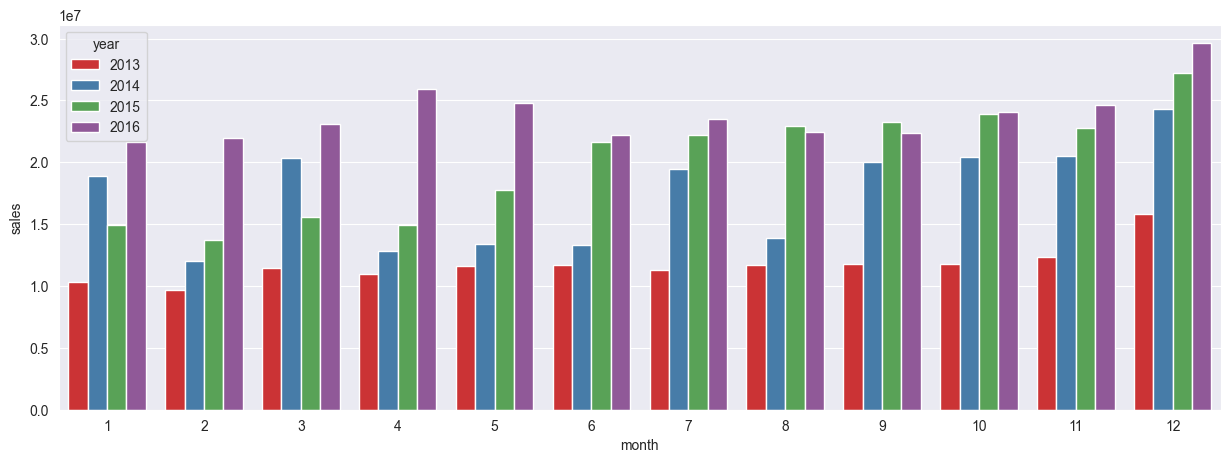

In [1169]:
plt.figure(figsize=(15, 5))

sns.barplot(x="month", y="sales", hue="year", data=month, palette="Set1", legend=True)

plt.show()

In [1170]:
month_promo = transaction_full.groupby(["month", "year"])["onpromotion"].sum().reset_index()


<AxesSubplot: xlabel='month', ylabel='onpromotion'>

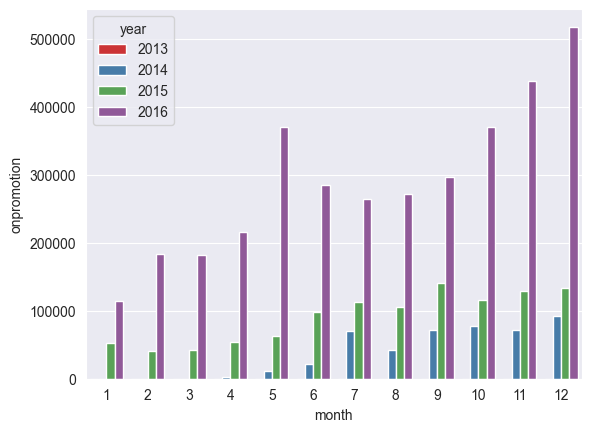

In [1171]:
sns.barplot(x="month", y="onpromotion", hue="year", data=month_promo, palette="Set1", legend=True)

**key points:**

1. The sales activity is increasing juny and july 2016. This is the time when earthquake happened in Ecuador (16 April 2016) and those days were holidays around one month. Number of promotion also increased in that month

2. The point is also in july 2014 the sales and oromotion slightly increased. This is the time when world cup 2014 happened in Brazil. Ecuador is one of the country that participated in the world cup. 

In [1172]:
month_holidays = holidays_filtered.groupby(["year", "month"])["national_holiday"].sum().reset_index()

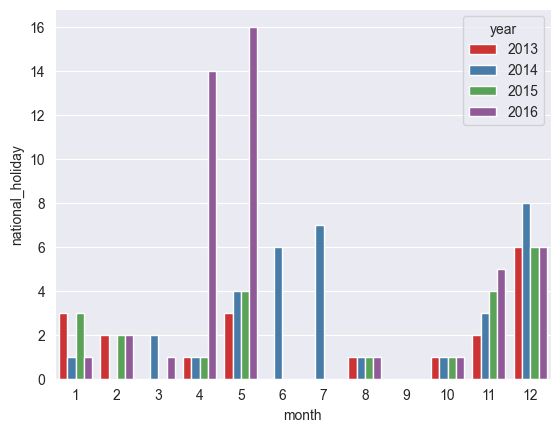

In [1173]:
sns.barplot(x="month", y="national_holiday", hue="year", data=month_holidays, palette="Set1", legend=True)

plt.show()

In [1174]:
transaction_full["agg_national_holiday"] = transaction_full.groupby(["year", "month", "day"])["national_holiday"].transform("sum")

In [1175]:
correlation_data = transaction_full[["sales", "transactions", "onpromotion", "dcoilwtico", "year", "month", "day"]].merge(month_holidays, left_on=["year", "month"], right_on=["year", "month"], how="left")


In [1176]:
correlation_data[["sales", "transactions", "onpromotion", "dcoilwtico", "national_holiday"]].corr()

sales  transactions  onpromotion  dcoilwtico  \
sales             1.000000      0.835647     0.289081   -0.236147   
transactions      0.835647      1.000000     0.088241    0.024343   
onpromotion       0.289081      0.088241     1.000000   -0.496605   
dcoilwtico       -0.236147      0.024343    -0.496605    1.000000   
national_holiday  0.109916      0.036697     0.226653   -0.138871   

                  national_holiday  
sales                     0.109916  
transactions              0.036697  
onpromotion               0.226653  
dcoilwtico               -0.138871  
national_holiday          1.000000

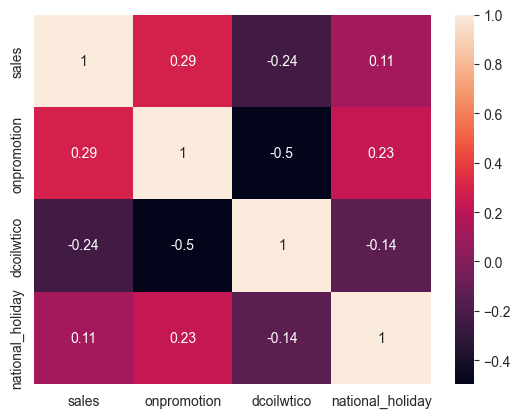

In [1177]:
#### Corerlation Sales and On Promotion

sns.heatmap(correlation_data[["sales", "onpromotion", "dcoilwtico", "national_holiday"]].corr(), annot=True)


plt.show()


**key points :**

1. If we see Sales and promotion as positive correlation and we can see from pearson correlation, it means that promotion is the can increase sales

2. Then oil price has high correlation with promotion, it mean it hopes with oil price decrease can increase customer to buy more product then with additional promotion can increase more sales

3. we can see aslo promotion has correaltion with holiday. it hopes in holidays customer can buy more product with additional promotion. However it is not as high as correaltion oil price with sales


#### Analysis by day

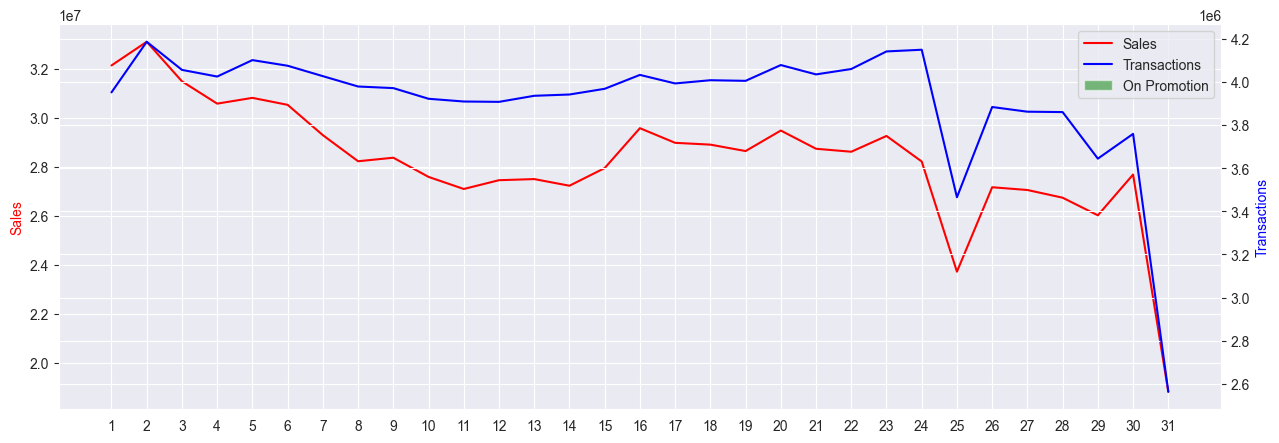

In [1178]:
fig, ax1 = plt.subplots(figsize=(15, 5))

ax2 = ax1.twinx()

ax1.plot(transaction_full.groupby("day")["sales"].sum(), color="red", label="Sales")
ax2.plot(transaction_full.groupby("day")["transactions"].sum(), color="blue", label="Transactions")

ax1.set_ylabel('Sales', color="red")
ax2.set_ylabel('Transactions', color="blue")

plt.xticks(np.arange(1,32, 1))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
plt.legend(lines + lines2 + lines3, labels + labels2 + labels3)

plt.xlabel("day")

plt.show()


we have low value in day 25 because we have missing days for 25 december

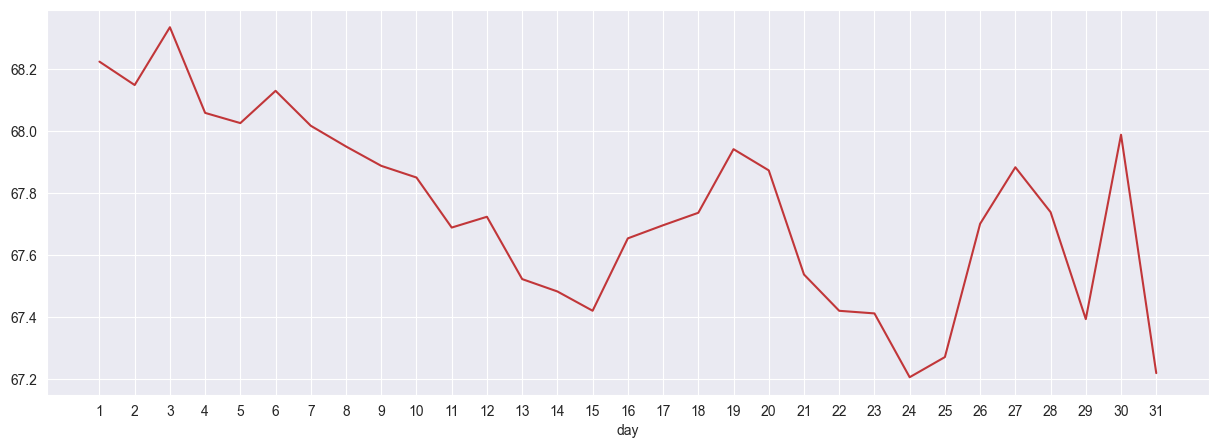

In [1179]:
oil.groupby("day")["dcoilwtico"].mean().plot(kind="line", figsize=(15, 5))

plt.xticks(np.arange(1, 32))

plt.show()

In [1180]:
train_viz.query("day == 26").tail()

id  store_nbr                      family        sales  \
date                                                                      
2016-12-26  2587459          9                     POULTRY   704.269960   
2016-12-26  2587460          9              PREPARED FOODS   105.548996   
2016-12-26  2587461          9                     PRODUCE  2030.049000   
2016-12-26  2587462          9  SCHOOL AND OFFICE SUPPLIES     0.000000   
2016-12-26  2587463          9                     SEAFOOD    12.000000   

            onpromotion  year  month weekday  day  
date                                               
2016-12-26            0  2016     12  Monday   26  
2016-12-26            2  2016     12  Monday   26  
2016-12-26            3  2016     12  Monday   26  
2016-12-26            0  2016     12  Monday   26  
2016-12-26            0  2016     12  Monday   26

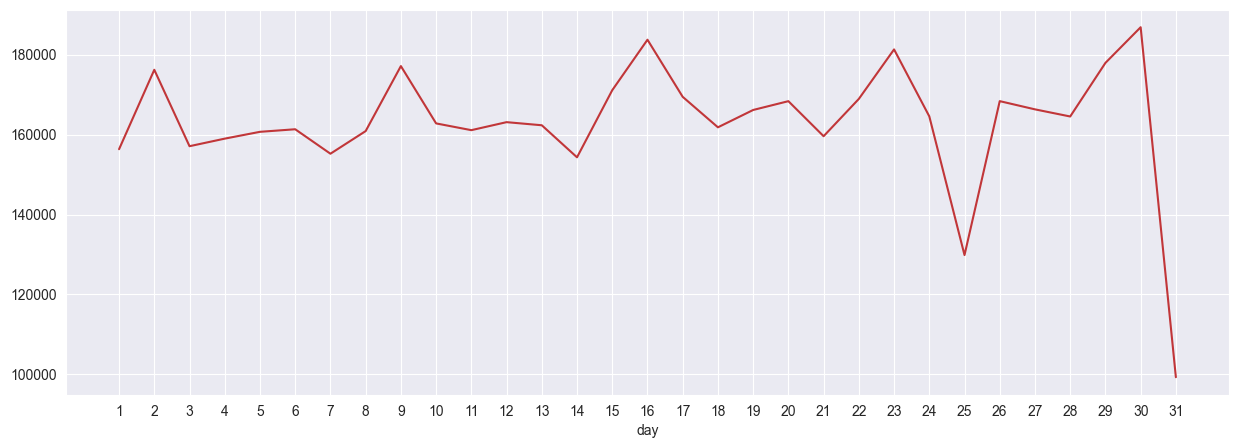

In [1181]:
transaction_full.groupby("day")["onpromotion"].sum().plot(kind="line", figsize=(15, 5))

plt.xticks(np.arange(1, 32))

plt.show()

**key points:**

As we can see sales and transactions are start to slightly increase when start the month and deacrease the slighly increase again when enter the middle of month because some wages are paid in the middle of month and end of month

#### Analysis by weekday

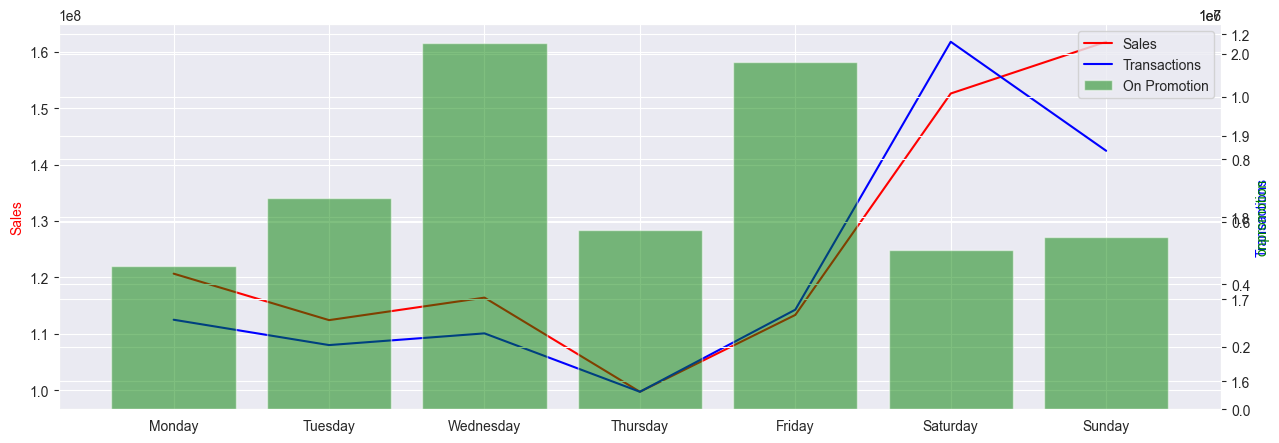

In [1182]:
fig, ax1 = plt.subplots(figsize=(15, 5))

ax2 = ax1.twinx()

ax1.plot(transaction_full.groupby("weekday")["sales"].sum(), color="red", label="Sales")
ax2.plot(transaction_full.groupby("weekday")["transactions"].sum(), color="blue", label="Transactions")

ax1.set_ylabel('Sales', color="red")
ax2.set_ylabel('Transactions', color="blue")

ax3 = ax1.twinx()
ax3.bar(transaction_full.groupby("weekday")["onpromotion"].sum().index, transaction_full.groupby("weekday")["onpromotion"].sum(), color="green", alpha=0.5, label="On Promotion")
ax3.set_ylabel('onpromotion', color="green")

plt.xticks(np.arange(0,7, 1), weekday_order)


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
plt.legend(lines + lines2 + lines3, labels + labels2 + labels3)

plt.xlabel("weekday")

plt.show()


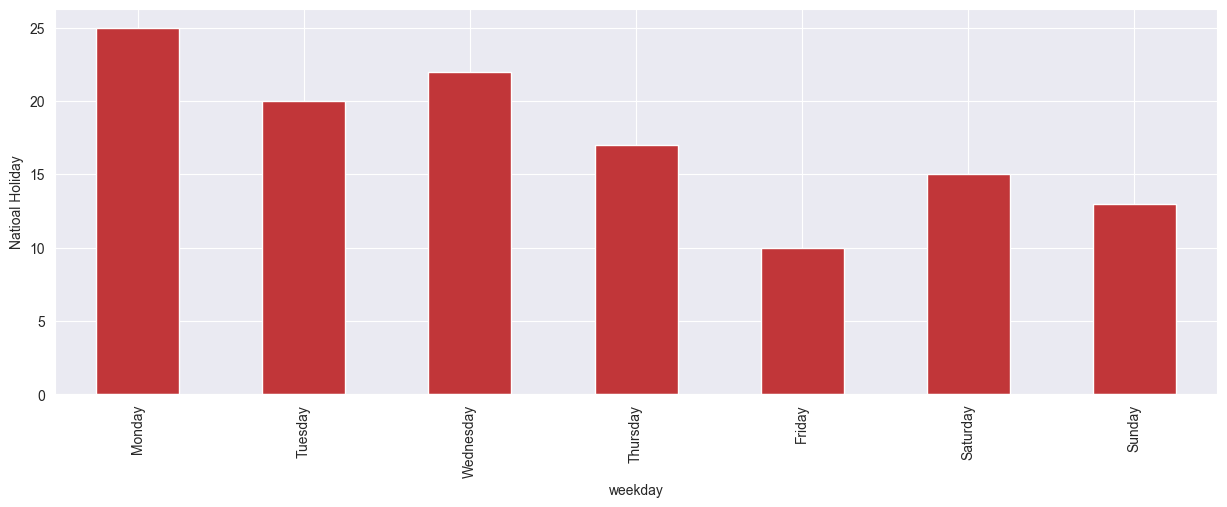

In [1183]:
holidays_filtered.groupby("weekday")["national_holiday"].sum().plot(kind="bar", figsize=(15, 5))

plt.xticks(np.arange(0,7, 1), weekday_order)
plt.ylabel("Natioal Holiday")

plt.show()

**key points :**


weekend still the highest sales

#### Analysis by Store

In [1184]:
transaction_full.head()

store_nbr  transactions  year  month  day  weekday     city  \
2013-01-01         25           770  2013      1    1        1  Salinas   
2013-01-02          1          2111  2013      1    2        2    Quito   
2013-01-02          2          2358  2013      1    2        2    Quito   
2013-01-02          3          3487  2013      1    2        2    Quito   
2013-01-02          4          1922  2013      1    2        2    Quito   

                  state type  cluster         sales  onpromotion       aov  \
2013-01-01  Santa Elena    D        1   2511.618999            0  3.261843   
2013-01-02    Pichincha    D       13   7417.148000            0  3.513571   
2013-01-02    Pichincha    D       13  10266.718981            0  4.353994   
2013-01-02    Pichincha    D        8  24060.348000            0  6.900014   
2013-01-02    Pichincha    D        9  10200.083980            0  5.307016   

            psr  local_holiday  regional_holiday  national_holiday  \
2013-01-01  0.0              0                 0              True   
2013-01-02  0.0              0                 0             False   
2013-01-02  0.0              0                 0             False   
2013-01-02  0.0              0                 0             False   
2013-01-02  0.0              0                 0             False   

            total_holiday  dcoilwtico  agg_national_holiday  
2013-01-01              1       93.14                     1  
2013-01-02              0       93.14                     0  
2013-01-02              0       93.14                     0  
2013-01-02              0       93.14                     0  
2013-01-02              0       93.14                     0

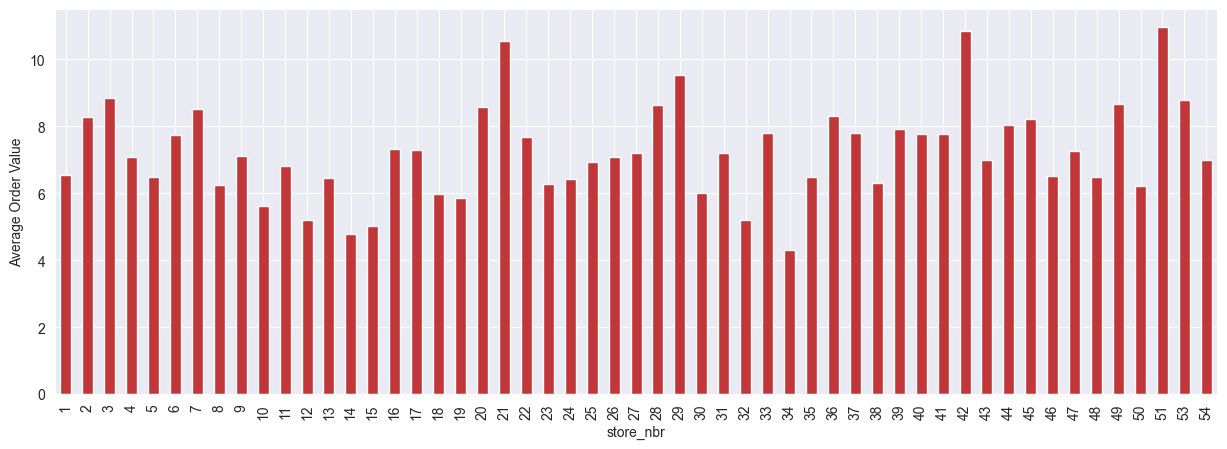

In [1185]:
transaction_full.groupby("store_nbr")["aov"].mean().plot(kind="bar", figsize=(15, 5))

plt.ylabel("Average Order Value")

plt.show()


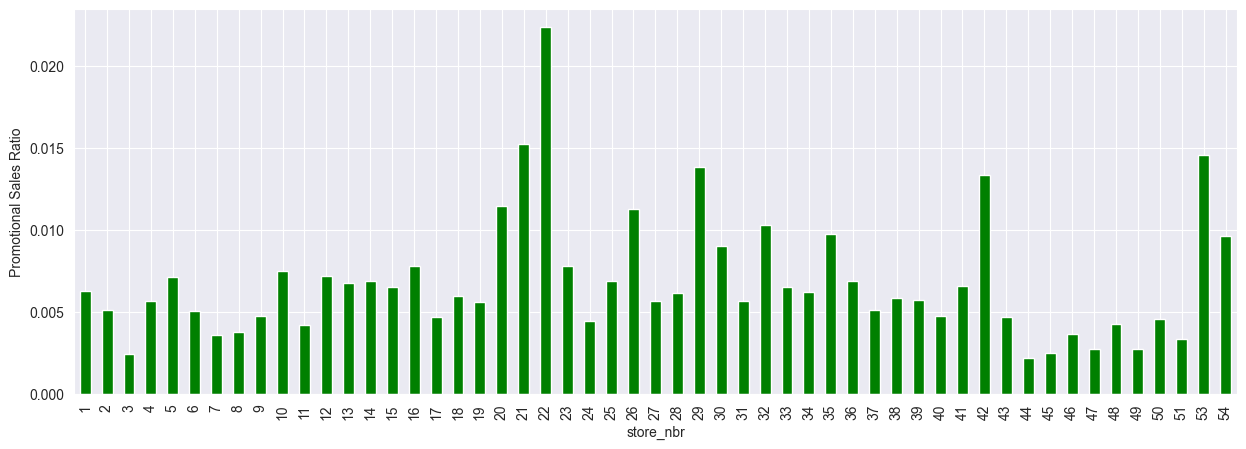

In [1186]:
transaction_full.groupby("store_nbr")["psr"].mean().plot(kind="bar",color = "green", figsize=(15, 5))

plt.ylabel("Promotional Sales Ratio")
plt.show()

we will take one store and see the sales and transactions

store 51 has low psr but higher aov

In [1187]:
store_51 = train_viz[train_viz["store_nbr"] == 51]

In [1188]:
store_51.groupby("family")["sales"].sum().sort_values(ascending=False).head()

family
GROCERY I    7.064510e+06
BEVERAGES    5.757994e+06
PRODUCE      4.377145e+06
CLEANING     2.105991e+06
DAIRY        2.085641e+06
Name: sales, dtype: float64

In [1189]:
store_51.groupby("family")["onpromotion"].sum().sort_values(ascending=False).head()

family
GROCERY I    26957
PRODUCE      20968
BEVERAGES    14588
DELI          7834
CLEANING      7812
Name: onpromotion, dtype: int64

store 22 has highest psr but the aov is not the higher

In [1190]:
store_22 = train_viz[train_viz["store_nbr"] == 22]

In [1191]:
store_22.groupby("family")["sales"].sum().sort_values(ascending=False).head(5)

family
GROCERY I    1.001842e+06
BEVERAGES    5.193260e+05
CLEANING     2.645490e+05
PRODUCE      1.642989e+05
DAIRY        1.265150e+05
Name: sales, dtype: float64

In [1192]:
store_22.groupby("family")["onpromotion"].sum().sort_values(ascending=False).head(5)

family
GROCERY I    15620
DAIRY         6965
BEVERAGES     5772
PRODUCE       5422
CLEANING      4835
Name: onpromotion, dtype: int64

we will see by type of the store

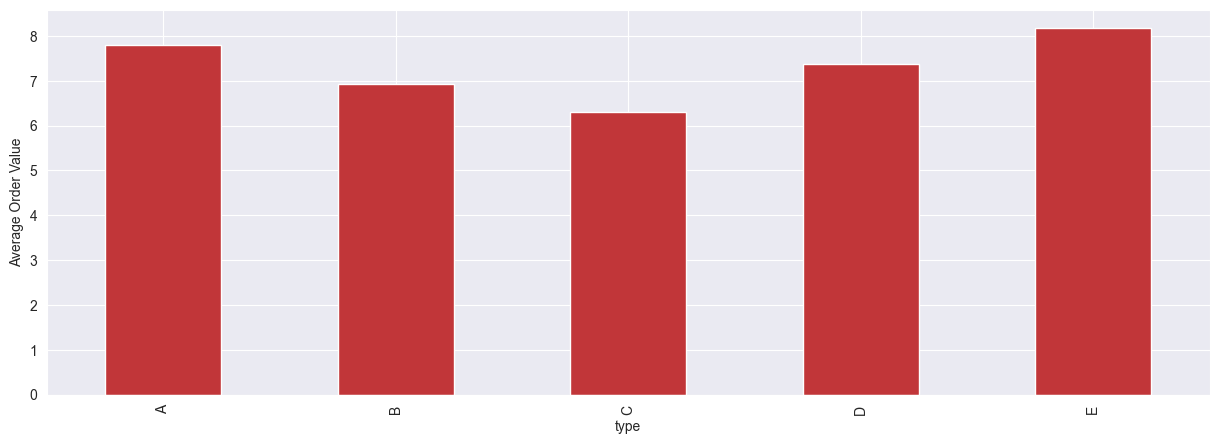

In [1193]:
transaction_full.groupby("type")["aov"].mean().plot(kind="bar", figsize=(15, 5))

plt.ylabel("Average Order Value")

plt.show()

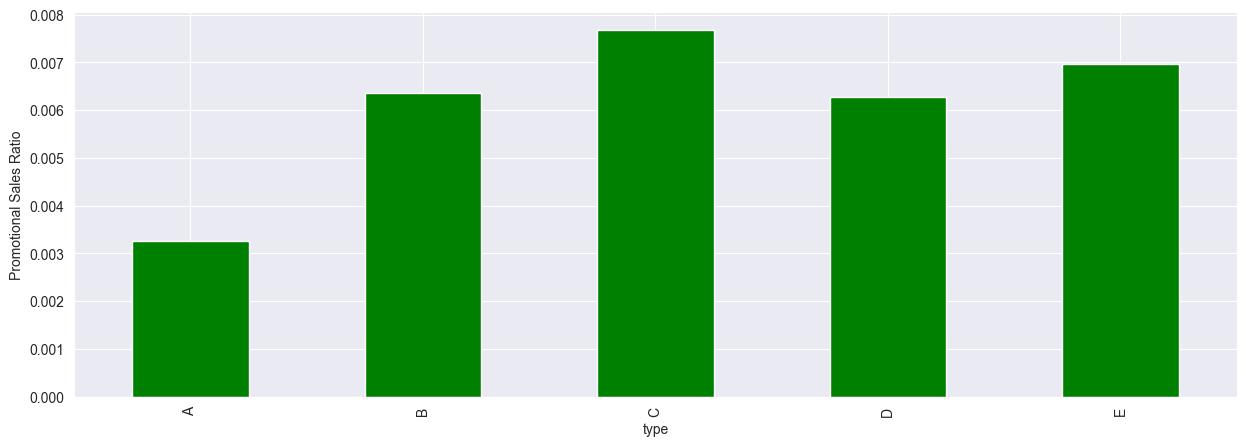

In [1194]:
transaction_full.groupby("type")["psr"].mean().plot(kind="bar", figsize=(15, 5), color = "green")

plt.ylabel("Promotional Sales Ratio")

plt.show()

store A is has lowest psr but has high aov

based the store_nbr in A, we can see the stores that have low psr

In [1195]:
a = transaction_full.query("type == 'A'")["store_nbr"].unique()
a

array([44, 45, 46, 47, 48, 49, 50, 51])

store C has has the highest psr but low aov

In [1196]:
c = transaction_full.query("type == 'C'")["store_nbr"].unique()
c

array([10, 12, 13, 14, 15, 16, 17, 19, 30, 32, 33, 35, 40, 54, 22])

In [1197]:
train_viz.query("store_nbr in @a").groupby("family")["sales"].sum().sort_values(ascending=False).head(5)

family
GROCERY I    8.795437e+07
BEVERAGES    5.735129e+07
PRODUCE      3.531288e+07
CLEANING     2.368491e+07
DAIRY        1.913834e+07
Name: sales, dtype: float64

In [1198]:
train_viz.query("store_nbr in @c").groupby("family")["sales"].sum().sort_values(ascending=False).head(5)

family
GROCERY I    5.400560e+07
BEVERAGES    2.579179e+07
CLEANING     1.763282e+07
PRODUCE      6.481227e+06
DAIRY        5.857098e+06
Name: sales, dtype: float64

In [1199]:
train_viz["psr"] = train_viz["onpromotion"] / train_viz["sales"]

key points :

in store analysis, we use two parameters to measure the performance of the store, which are average order value and promotional sales ratio.

average order value is the average of sales per transaction. the higher the average order value, the better the performance of the store.
promotion sales ratio is the ratio of sales that come from promotion. the higher the promotion sales ratio means there are some sales that come from promotion. the smaller psr means that can be small number of sales on promotion is small but total sales still high. So the store is effective even without promotion.


1. The interesting stores come from store that have high aov but small psr wich comes from some stores in 44-51 (store with "type" A) especially for the store **51**.
vice versa, the store that have low aov but high psr comes from some stores especially **22**.

    it means store 51 is effective even with small promotion and store 22 is not effective with promotion

2. There is also probably sales is higher because the family product has different unit size. for example, the family with the highest sales is beverages. it is probably because the unit size of beverages, produce is bigger than other family. so the sales is higher. You can notice from agregation above about sales data by family especially like produce.


**check by the city**

based on the type we can see if the stores is almost from Quito and also one additional store from Quayaquil. These city is the capital of the country and also the biggest city in the Equador or crowded city. So we can assume that the stores are in the crowded city in equador

#### Analysis by family product

we will work mostly in data train so we need to merge with other data

In [1200]:
train_oil = train_viz.merge(oil[["dcoilwtico"]], left_index=True, right_index=True, how="left")

In [1201]:
train_merge = train_oil.merge(holidays_filtered[["national_holiday"]], left_index=True, right_index=True, how="left")

in here I just focus for national holiday to make it simple

##### General distribution of family

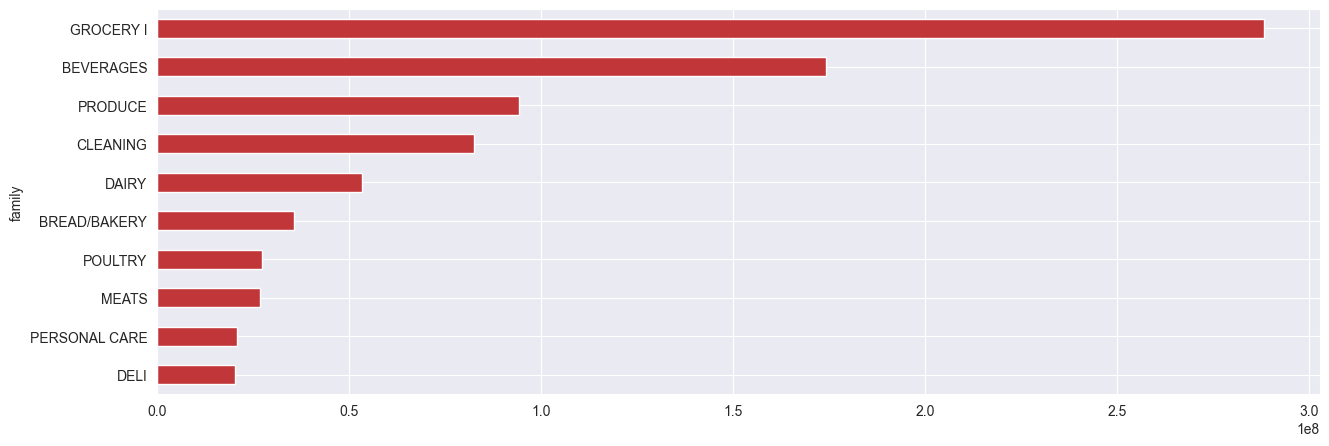

In [1202]:
train_merge.groupby("family")["sales"].sum().sort_values(ascending=False).head(10).plot(kind="barh", figsize=(15, 5)).invert_yaxis()

In [1203]:
train_family = train.groupby(["family", "year", "month"])["sales"].sum().reset_index()

In [1204]:
train_family.sort_values(by = ["family", "year", "month"], inplace = True)

In [1205]:
#this is 3 faimily with highest sales 
BestFamily = ["GROCERY I", "BEVERAGES", "PRODUCE"]

In [1206]:
train_family_best = train_family[train_family["family"].isin(BestFamily)]

In [1207]:
train_family_best["pct_change"] = train_family_best["sales"].pct_change()*100

In [1208]:
train_family_best.loc[train_family_best["month"] == 1, "pct_change"] = 0

In [1209]:
train_family_best.query("family == 'GROCERY I'").sort_values(by = ["pct_change"], ascending=False).head(5)

family  year  month        sales  pct_change
695  GROCERY I  2014     12  7465455.145   30.800007
719  GROCERY I  2016     12  9454952.927   29.115319
683  GROCERY I  2013     12  6451806.000   28.334847
711  GROCERY I  2016      4  8408542.133   25.171946
707  GROCERY I  2015     12  8354408.355   24.923610

In [1210]:
train_family_best.query("family == 'BEVERAGES'").sort_values(by = ["pct_change"], ascending=False).head(5)

family  year  month      sales  pct_change
182  BEVERAGES  2014      3  4430194.0  131.130146
188  BEVERAGES  2014      9  4304900.0  104.098275
186  BEVERAGES  2014      7  4175817.0   98.765326
196  BEVERAGES  2015      5  3534100.0   53.180530
197  BEVERAGES  2015      6  4767226.0   34.892221

In [1211]:
train_family_best.query("family == 'PRODUCE'").sort_values(by = ["pct_change"], ascending=False).head(5)

family  year  month         sales    pct_change
1682  PRODUCE  2013      3  4.037000e+03           inf
1694  PRODUCE  2014      3  3.352346e+06  5.087850e+04
1700  PRODUCE  2014      9  3.388715e+06  4.090078e+04
1698  PRODUCE  2014      7  3.216023e+06  3.872679e+04
1709  PRODUCE  2015      6  3.519217e+06  3.449710e+04

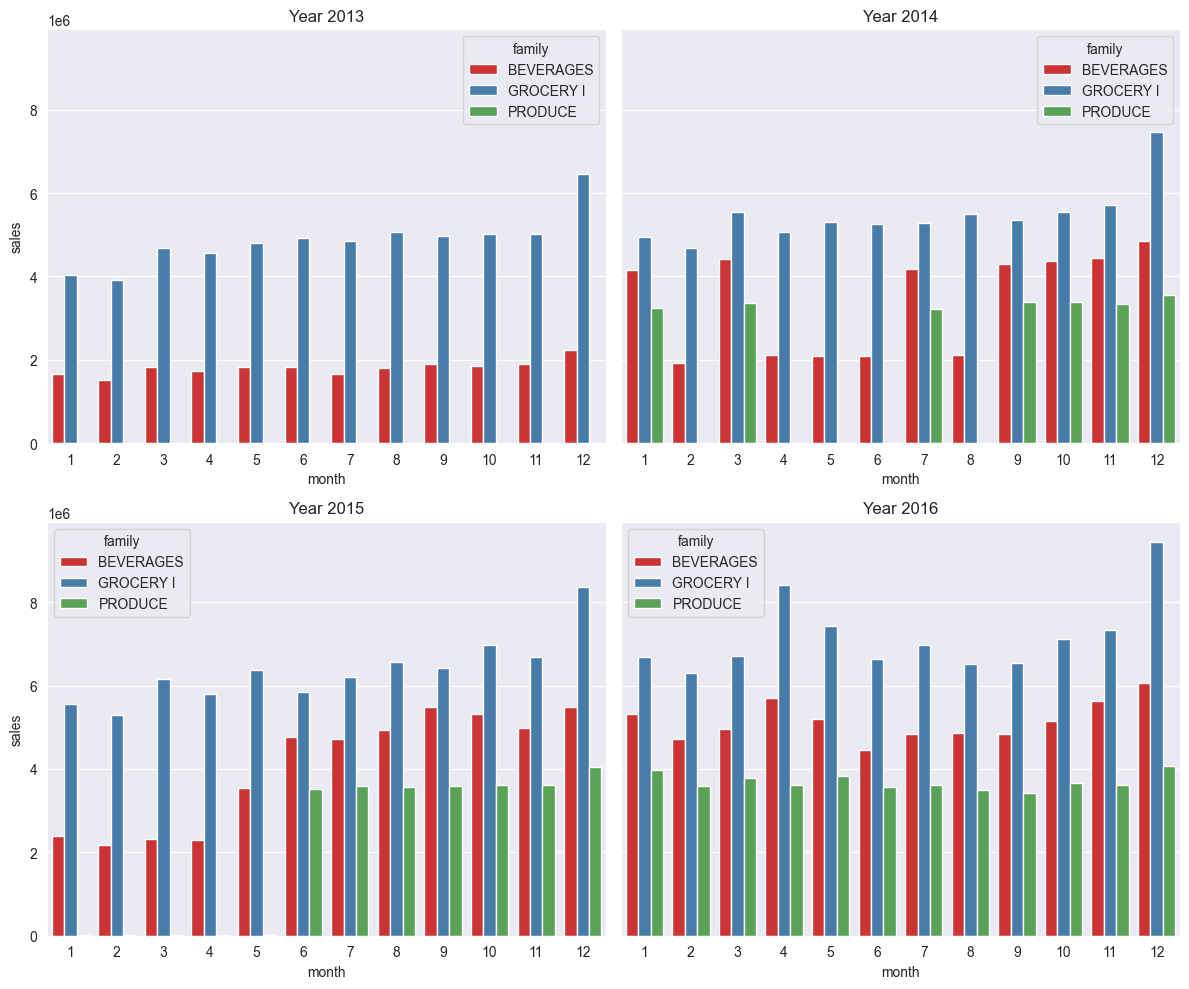

In [1212]:
years = [2013, 2014, 2015, 2016]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for i, year in enumerate(years):
    viz_year = train_family_best[train_family_best["year"] == year]
    
    row = i // 2
    col = i % 2
    
    sns.barplot(x="month", y="sales", hue="family", data=viz_year, palette="Set1", ax=axes[row, col])
    axes[row, col].set_title(f'Year {year}')

plt.tight_layout()
plt.show()


**Key Points :**

1. "GROCERY I" family has always increase sales from November to December
2. "BEVERAGES" family can increase sales that depends on the events like in 2014 there are world cup and carnavales
3. there is something wrong with the "PRODUCE" family and we will see in the bar plot. which is fluctuatif except in 2016

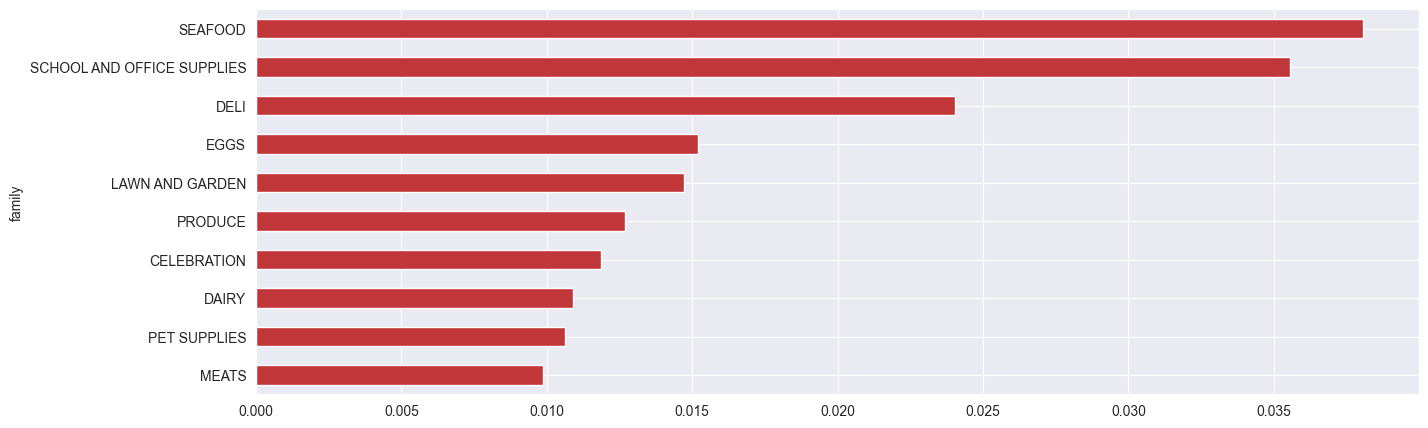

In [1213]:
train_merge.groupby("family")["psr"].mean().sort_values(ascending=False).head(10).plot(kind="barh", figsize=(15, 5)).invert_yaxis()

dataframe that show family that have highest psr or promotional sales ratio or onpromotion/sales for each store

In [1214]:
from IPython.core.display import display, HTML

def display_data(data):
    html_content = f'<div style="max-height: 200px; overflow-y: scroll;">{data.to_html()}</div>'
    return display(HTML(html_content))


In [1215]:
store_family = train_viz.groupby(["store_nbr", "family"])["psr"].mean().reset_index()

In [1216]:
store_family.fillna(0, inplace=True)

In [1217]:
store_family_html = store_family.loc[store_family.groupby("store_nbr")["psr"].idxmax()]

display_data(store_family_html)

Key Points : 

There are theree important family in store because that still can give sales even though there is small promotion which are "SEAFOOD", "DELI", and "SCHOOL AND OFFICE SUPPLIES"

In [1218]:
corr = train_merge.groupby(["day","month", "year","family"]).agg({"sales" : sum, "onpromotion" : sum, "dcoilwtico" : np.mean}).reset_index()

In [1219]:
corr["date"] = pd.to_datetime(corr[["year", "month", "day"]])
corr.set_index("date", inplace=True)

corr.drop(["day", "month", "year"], axis=1, inplace=True)

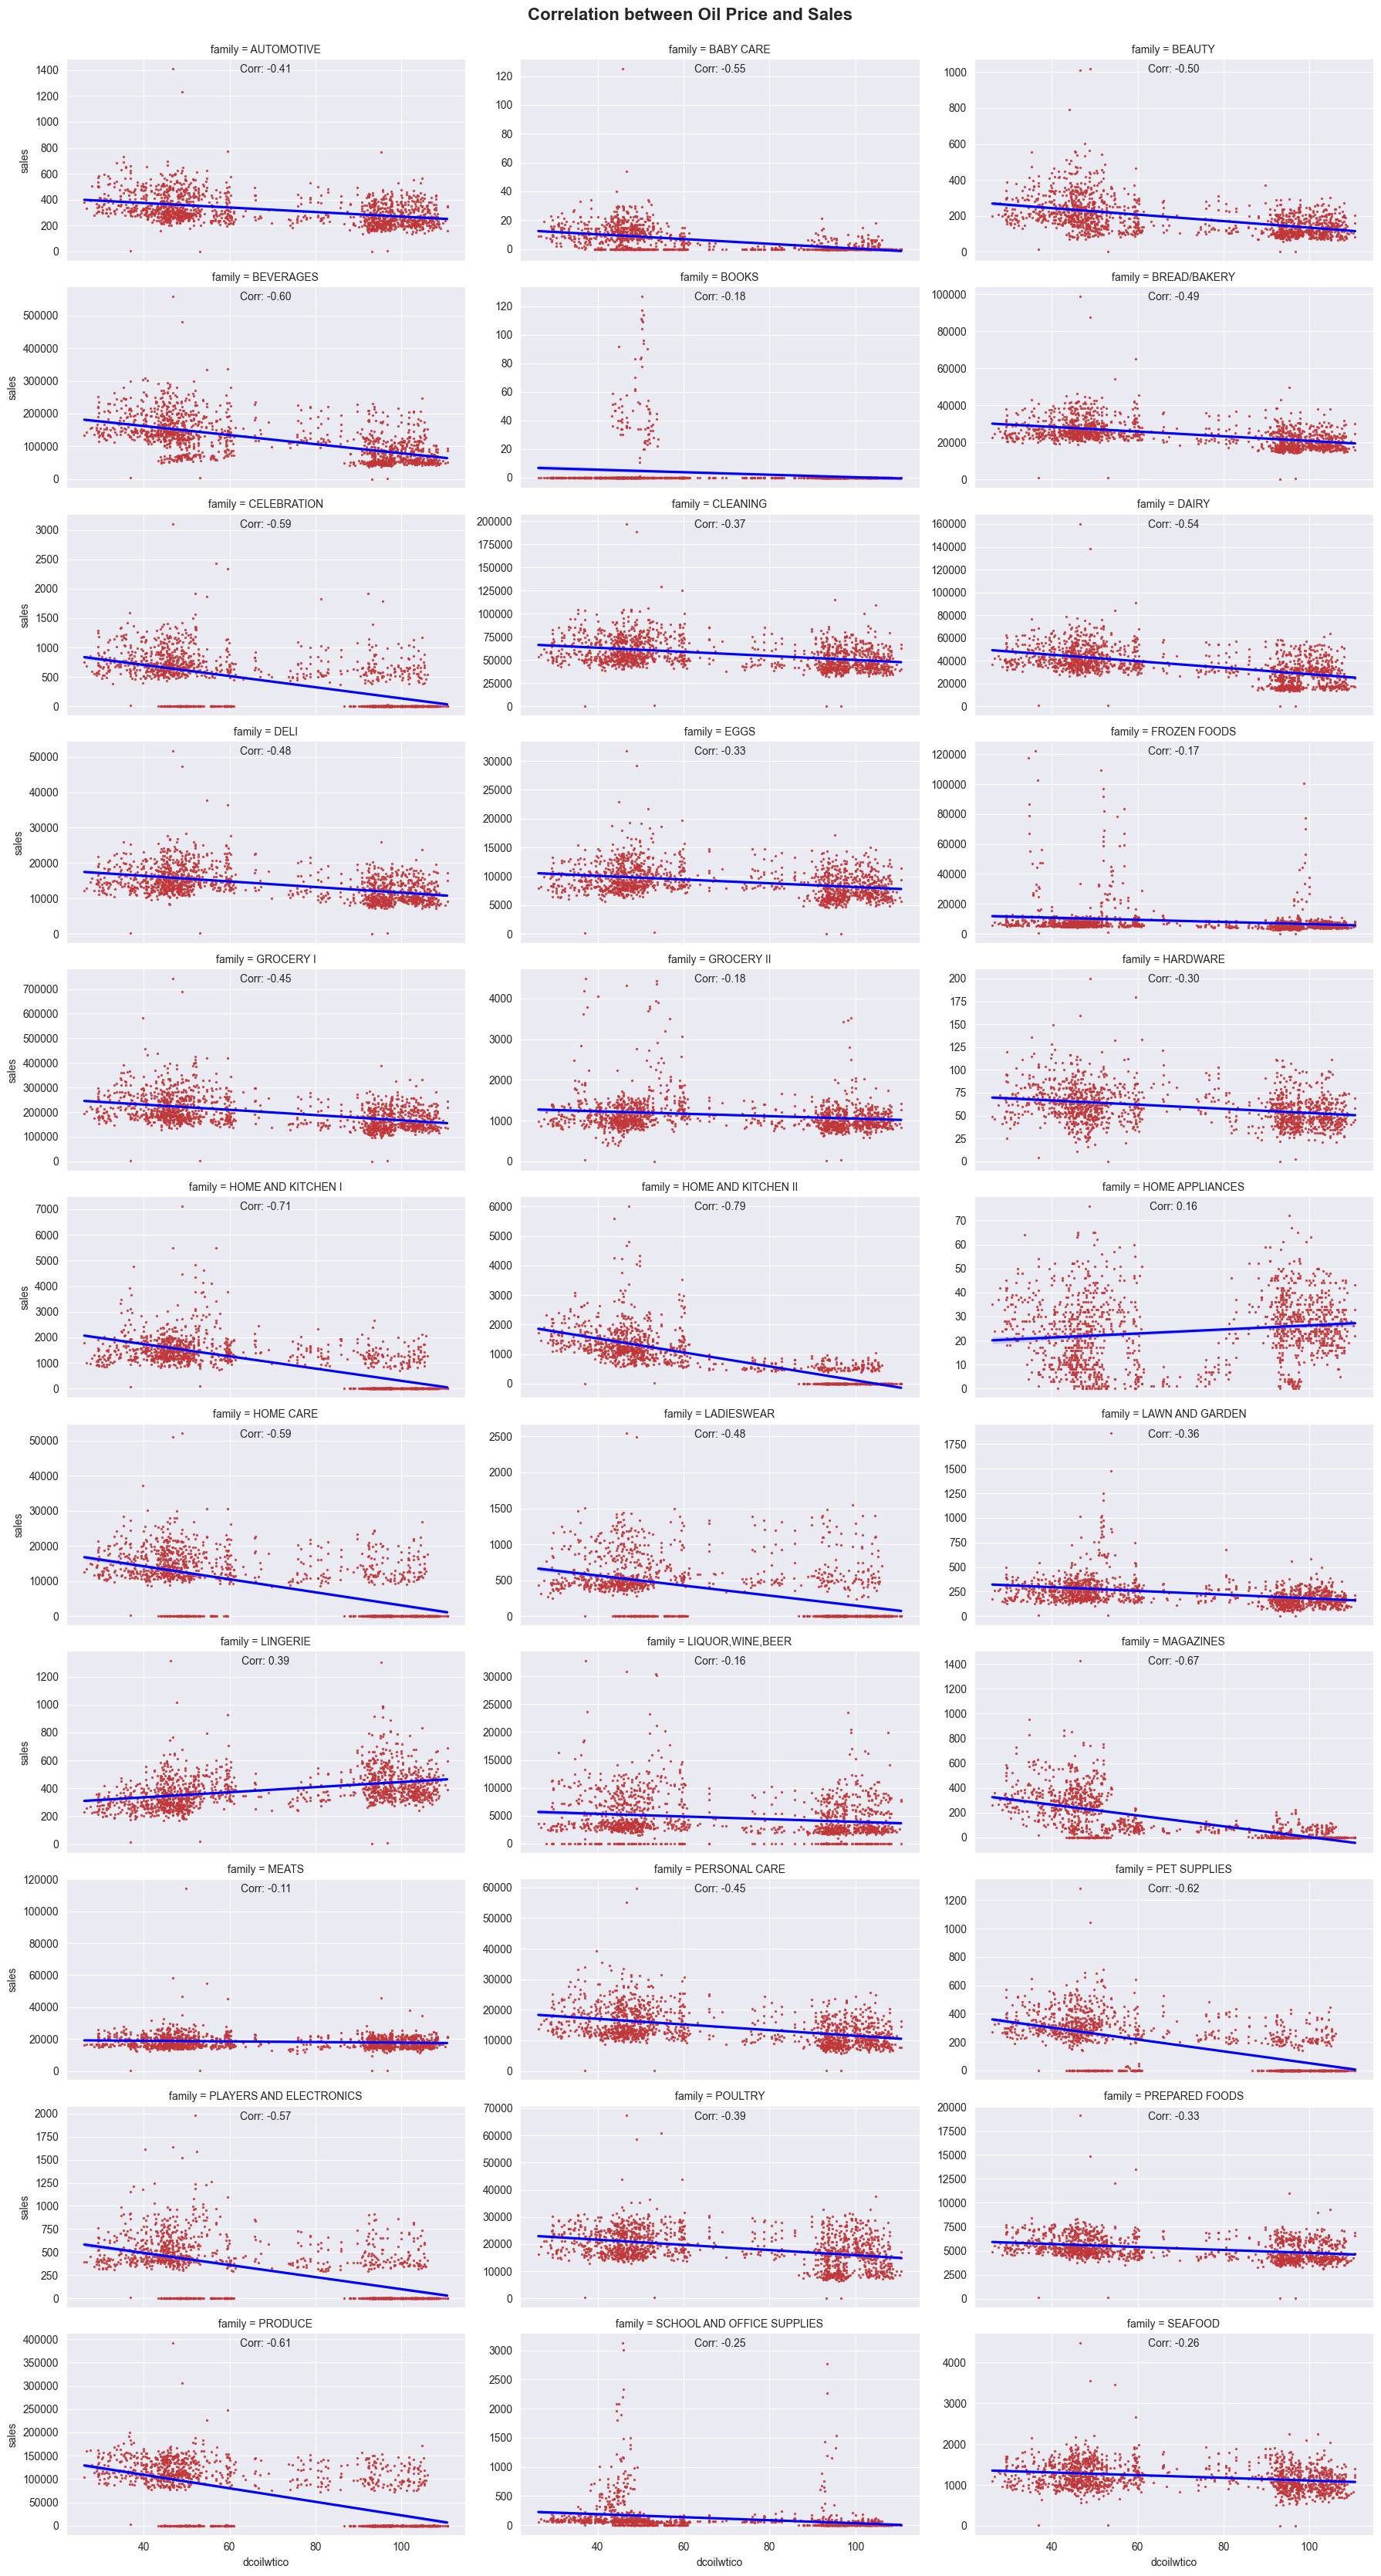

In [1220]:
g = sns.lmplot(x="dcoilwtico", y="sales", data=corr, col="family", height=3, aspect=2, col_wrap=3, sharey=False, line_kws={'color': 'blue'}, scatter_kws={'s': 2})

def annotate_corr(x, y, **kwargs):
    corr_coeff, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.text(0.5, 0.95, f'Corr: {corr_coeff:.2f}', transform=ax.transAxes, ha='center', va='center')

g.map(annotate_corr, "dcoilwtico", "sales")

plt.suptitle("Correlation between Oil Price and Sales", y = 1.01, fontsize = 16, fontweight = "bold")

plt.show()

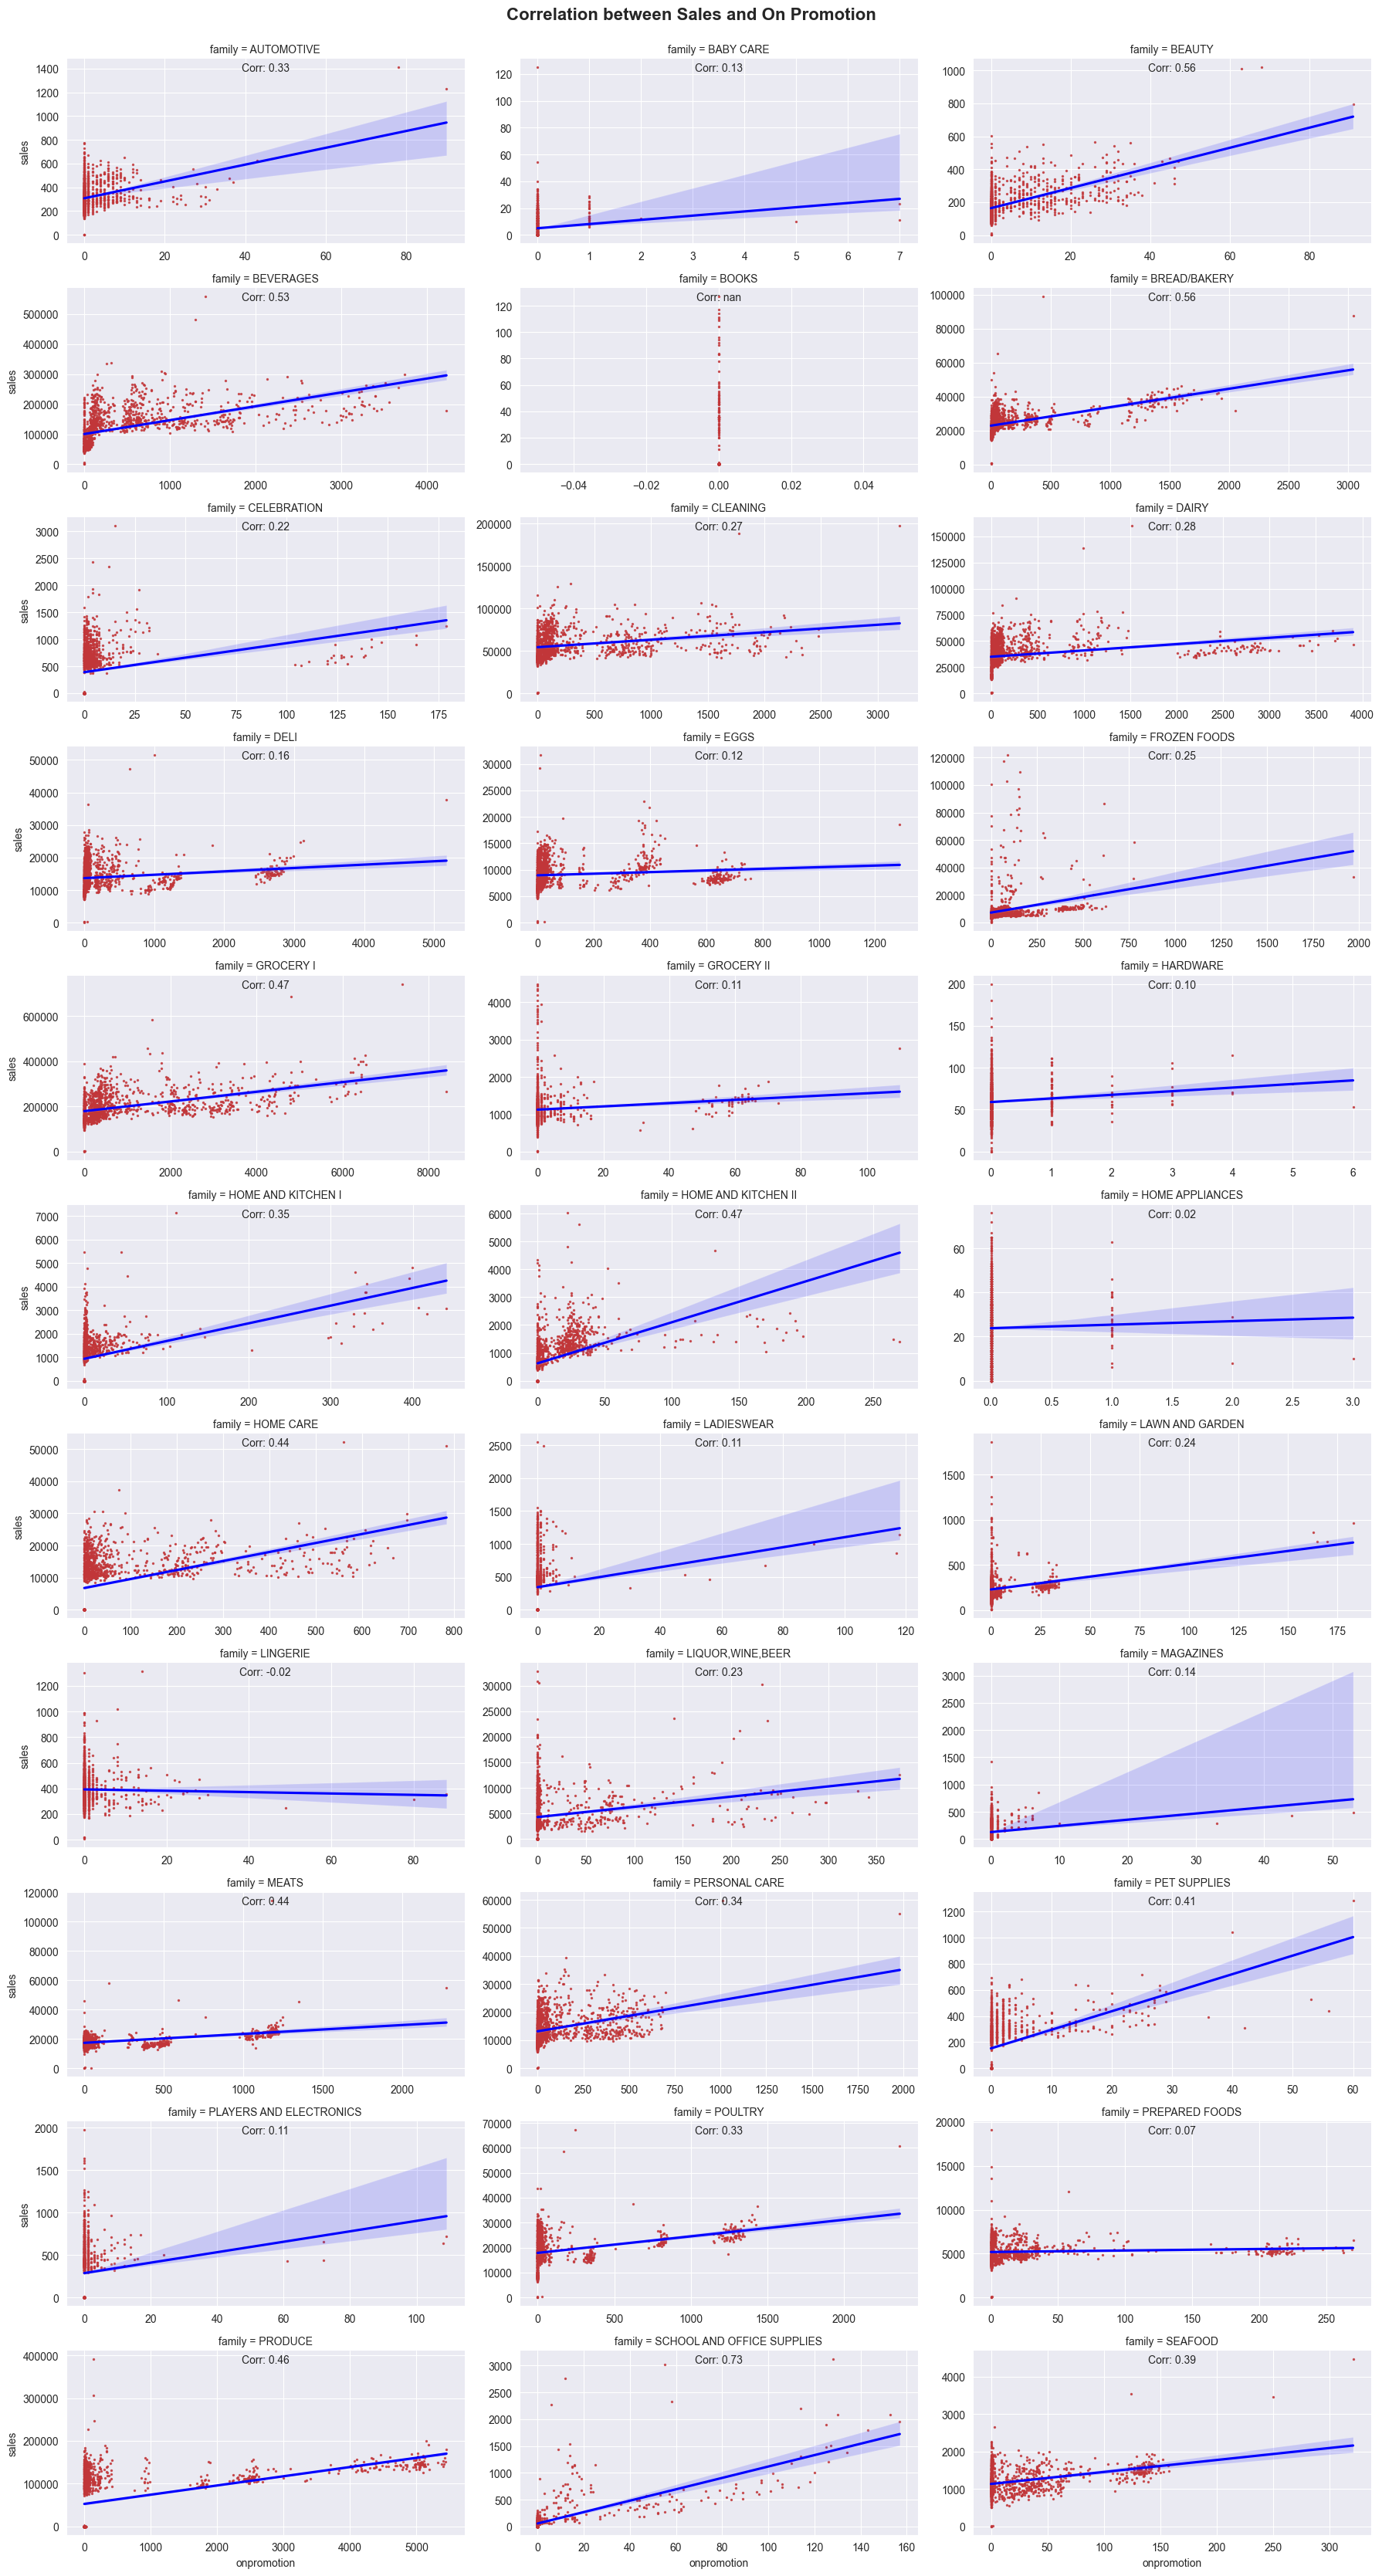

In [1221]:
g = sns.lmplot(x="onpromotion", y="sales", data=corr, col="family", height=3, aspect=2, col_wrap=3, sharey=False, line_kws={'color': 'blue'}, scatter_kws={'s': 2}, sharex=False)

def annotate_corr(x, y, **kwargs):
    corr_coeff, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.text(0.5, 0.95, f'Corr: {corr_coeff:.2f}', transform=ax.transAxes, ha='center', va='center')

g.map(annotate_corr, "onpromotion", "sales")

plt.suptitle("Correlation between Sales and On Promotion", y=1.01, fontsize = 16, fontweight = 'bold')

plt.show()

**Key Points :**

we will see the correalation between sales and oil price, and sales and onpromotion for each family

1. Sales and Oil Price has a negative correlation. There are some family that has a strong negative correlation such as HOME KITCHEN, MAGAZINES, PET SUPPLIES
2. Sales and On Promotion has a positive correlation. There are some family that has a strong positive correlation such as OFFICE SUPPLIES, BEAUTY, BREAD/BAKERY

#### Percentage change sales 2013 to 2016 

In [1222]:
store_family_nbr = train_merge.groupby(["family", "store_nbr", "year"]).agg({"sales":sum, "onpromotion" : sum}).reset_index()

In [1223]:
store_family_nbr = store_family_nbr.query("year == 2013 or year == 2016")

In [1224]:
store_family_nbr["pct_change"] = store_family_nbr["sales"].pct_change()*100

store_family_nbr.loc[store_family_nbr["year"] == 2013, "pct_change"] = 0

In [1225]:
family_pct_change = store_family_nbr.query("year == 2016")
family_pct_change["pct_change"] = family_pct_change["pct_change"].apply("{:.2f}".format).astype(float)
family_pct_change = family_pct_change.query("(pct_change != inf) and (pct_change != 0)")
family_pct_change.dropna(inplace=True)

display_data(family_pct_change)

**Key Points**

Below is dataframe that has the highest percentage change in sales in 2016 compared to 2013

so, we can see which store for each family has the highest percentage change in sales in 2016 compared to 2013. In Example AUTOMATIVE in store number 36

In [1226]:
display_data(family_pct_change.loc[family_pct_change.groupby("family")["pct_change"].idxmax()])

In [1227]:
family_pct_change.loc[family_pct_change.groupby("family")["pct_change"].idxmax()]["store_nbr"].value_counts()

36    10
54     3
49     2
17     2
35     1
14     1
39     1
12     1
8      1
Name: store_nbr, dtype: int64

**Key Points**

store_nbr 36 is the store with the 10 family products that have the highest pct change from 2013 to 2016

#### Store Number

In [1228]:
store_nbr = train_merge.groupby(["store_nbr", "year"]).agg({"sales":sum, "onpromotion" : sum}).reset_index()

In [1229]:
store_nbr = store_nbr.query("year == 2013 or year == 2016")

In [1230]:
store_nbr["pct_change"] = store_nbr["sales"].pct_change()*100

store_nbr.loc[store_nbr["year"] == 2013, "pct_change"] = 0

In [1231]:
store_pct_change = store_nbr.query("year == 2016")
store_pct_change["pct_change"] = store_pct_change["pct_change"].apply("{:.2f}".format).astype(float)
store_pct_change = store_pct_change.query("(pct_change != inf) and (pct_change != 0)")
store_pct_change.dropna(inplace=True)

display_data(store_pct_change)

below we can see percentage change of sales in 2016 compared to 2013 for each store. In example Store Number 36 and 49 have the pct change are 238 and 204 respectively. This means that the sales in 2016 are 238% and 204% higher than in 2013.

##### store with sales 0

In [1232]:
store_family = train_merge.groupby(["store_nbr", "family"])["sales"].sum().reset_index()

In [1233]:
store_family = train_merge.groupby(["store_nbr", "family"]).agg({"sales" : sum, "psr" : sum}).reset_index()


below is family that dont sell in store. So we can drop later to help us when we do forecasting

In [1234]:
zero_sales = store_family.query("sales == 0")
display_data(zero_sales)

### Summary

we have some key points for each analysis section. But we just point out for some important points that we found and can help for the forecasting model

from types import CoroutineType


1. There are two point that we can see the in positive correlation between sales and promotion.
   
   these two parameter are oil price and national holidays that can effect on the sales activity in the store especially when add with the promotion

   * On promotion has high negative correlation with oil price
   * On promotion has high positive correlation with national holidays

   however oil price has high correlation than national holidays

2. There are some certain condition that can effect on the sales activity like world cup, earthquake, some events, payment day, and so on. Especially earthquare that effect to the sales activity in the 2016 but with high promotion that still can keep sales activity
 
3. We can see some store number and family product based on promotion sales ratio (psr), average order value(aov), and percentage change of sales. This can help to know which store and which product that can be improve for the sales activity.

   * There are some store with low psr but high aov especially in big city like in cluster A and also vice versa.
   * There are some store with high percentage change of sales compare 2013 to 2016 like in store 36.
   

4. There are some family product that can be improve for the sales and efficiency promotion because there are some family products that have correlation with oil price ("HOME KITCHEN", "MAGAZINES", "PET SUPPLIES") and promotion ("OFFICE SUPPLIES", "BEAUTY", "BREAD/BAKERY"). But also some family product that has low psr that means still have high sales with low promotion ("SEAFOOD", "DELI", and "SCHOOL AND OFFICE SUPPLIES")

## Time Series Forecasting

### Scoring

based on the description, we will use this score to evaluate the score but also using the other scoring like mse and rmse

In [1664]:
from sklearn.metrics import mean_squared_error

In [1665]:
from sklearn.metrics import make_scorer

In [1666]:
from sklearn.metrics import make_scorer


def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))


make_scorer(rmsle, greater_is_better=False)

make_scorer(rmsle, greater_is_better=False)

### EDA & Data Preprocessing

before to do forecasting, we start to prepare the data 

 we merge some data and also include the data 2017

In [1667]:
oil.fillna(method="ffill", inplace=True)

In [1668]:
train.drop(columns="id", inplace = True)

KeyError: "['id'] not found in axis"

In [1669]:
# want to filter holiday events filtered to only until train data

holidays_events_filtered_train = holidays_events_filtered[holidays_events_filtered.index <= train.index.max()]

In [1670]:
df_train = (train
            .merge(stores, on="store_nbr", how="left").set_index(train.index)
            .merge(oil[["dcoilwtico"]], left_index=True, right_index=True, how="left").set_index(train.index)
            .merge(holidays_events_filtered_train[["national"]], left_index=True, right_index=True, how="left")
           )


In [1671]:
df_train.reset_index(inplace=True)

In [1672]:
df_train = df_train.merge(pd.DataFrame(pd.date_range(start="2013-01-01", end="2017-08-15"), columns=["date"]), on="date", how="outer")

In [1673]:
df_train.set_index("date", inplace=True)

In [1674]:
df_train["sales"] = df_train["sales"].interpolate(method="linear")

just for remind if the data in 2017 is only untul middle of august

In [1675]:
frequencies = ["Y", "M", "W", "D"]

In [1676]:
def plot_sales_frequency(summary_func="sum"):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    for i, freq in enumerate(frequencies):
        df_resampled = df_train.resample(freq)["sales"].agg(summary_func)
        ax[i // 2, i % 2].plot(df_resampled, label=f"{summary_func.capitalize()} {freq} Sales")
        ax[i // 2, i % 2].set_title(f"{summary_func.capitalize()} {freq} Sales")

    plt.tight_layout()

    plt.suptitle(f"Total {summary_func.capitalize()} Sales Frequency", y=1.01, fontsize=16, fontweight="bold")

    plt.show()



sum sales frequency

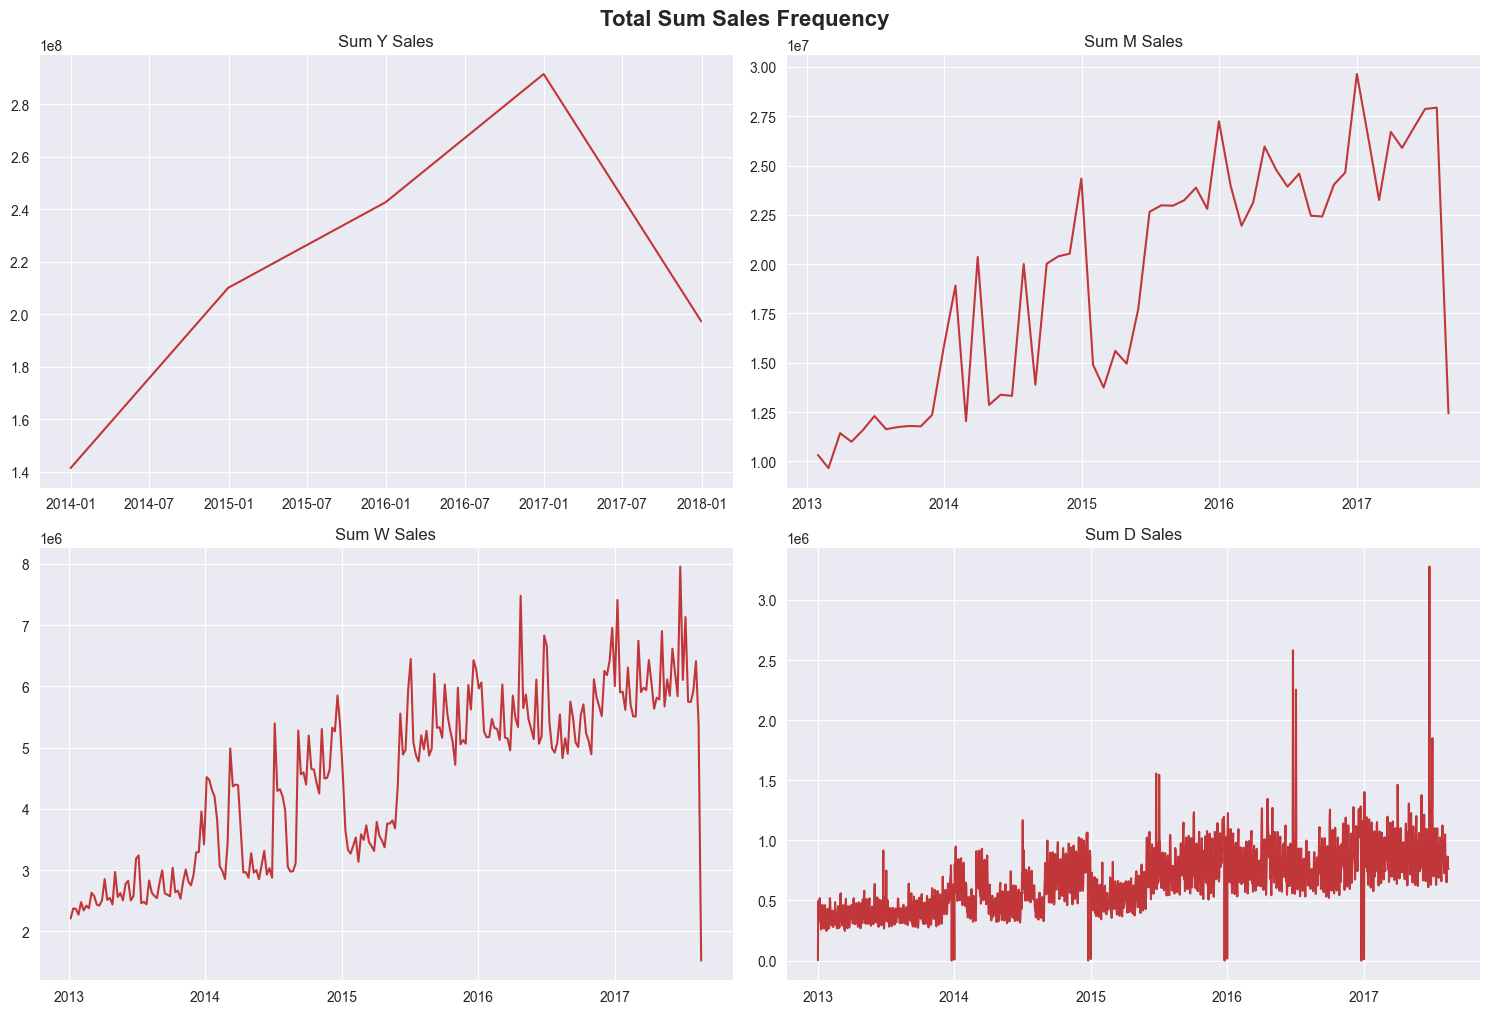

In [1677]:
plot_sales_frequency("sum")

mean sales frequency

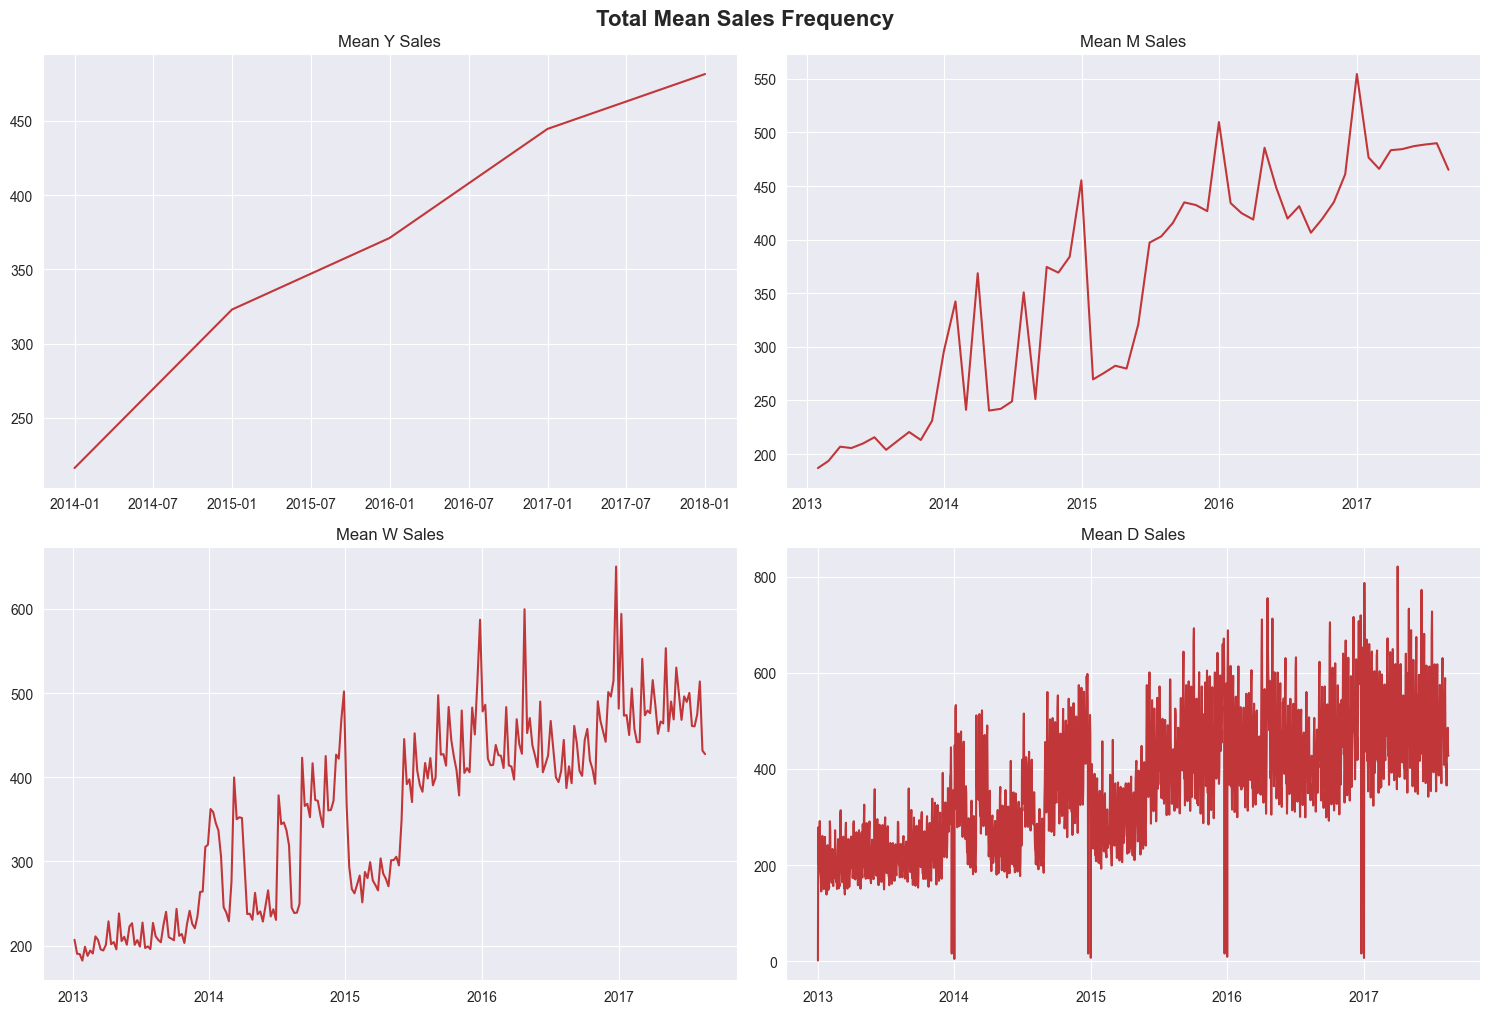

In [1678]:
plot_sales_frequency(summary_func="mean")

if wee see the mean sales frequency we can see that the sales are increasing for each year or there is trend. Besides that we can see if there is seasonal pattern in the data

In [1679]:
### sample data

sample_data = df_train.groupby(df_train.index)["sales"].sum().reset_index()

In [1680]:
sample_data.set_index("date", inplace=True)

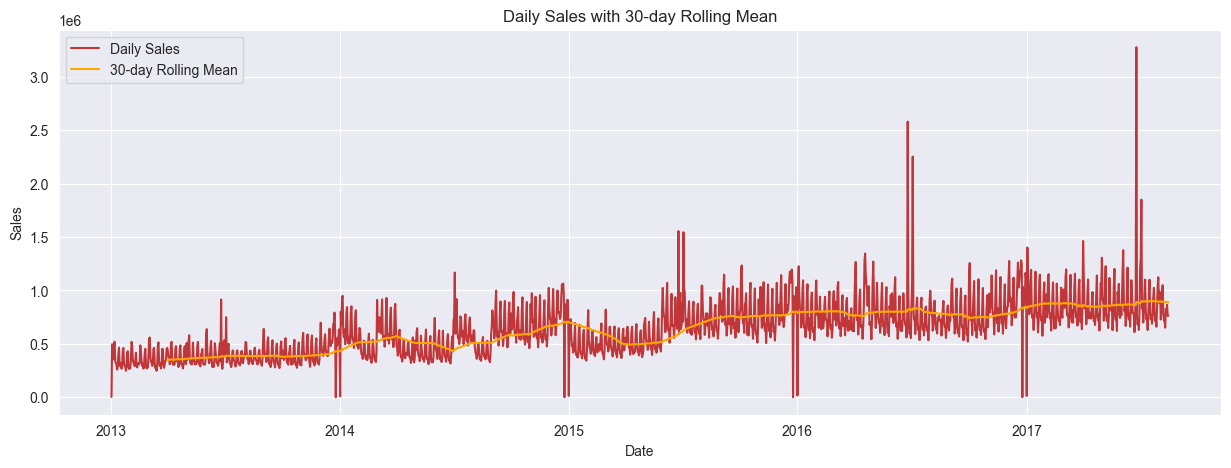

In [1681]:
df_daily_mean = sample_data["sales"]
df_rolling_mean = df_daily_mean.rolling(window=90).mean()

plt.figure(figsize=(15, 5))

plt.plot(df_daily_mean.index, df_daily_mean, label="Daily Sales")
plt.plot(df_rolling_mean.index, df_rolling_mean, label="30-day Rolling Mean", color='orange')

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Daily Sales with 30-day Rolling Mean")
plt.legend()
plt.show()

In [1682]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [1683]:
result = seasonal_decompose(sample_data["sales"], period=365, model='multiplicative', extrapolate_trend='freq')

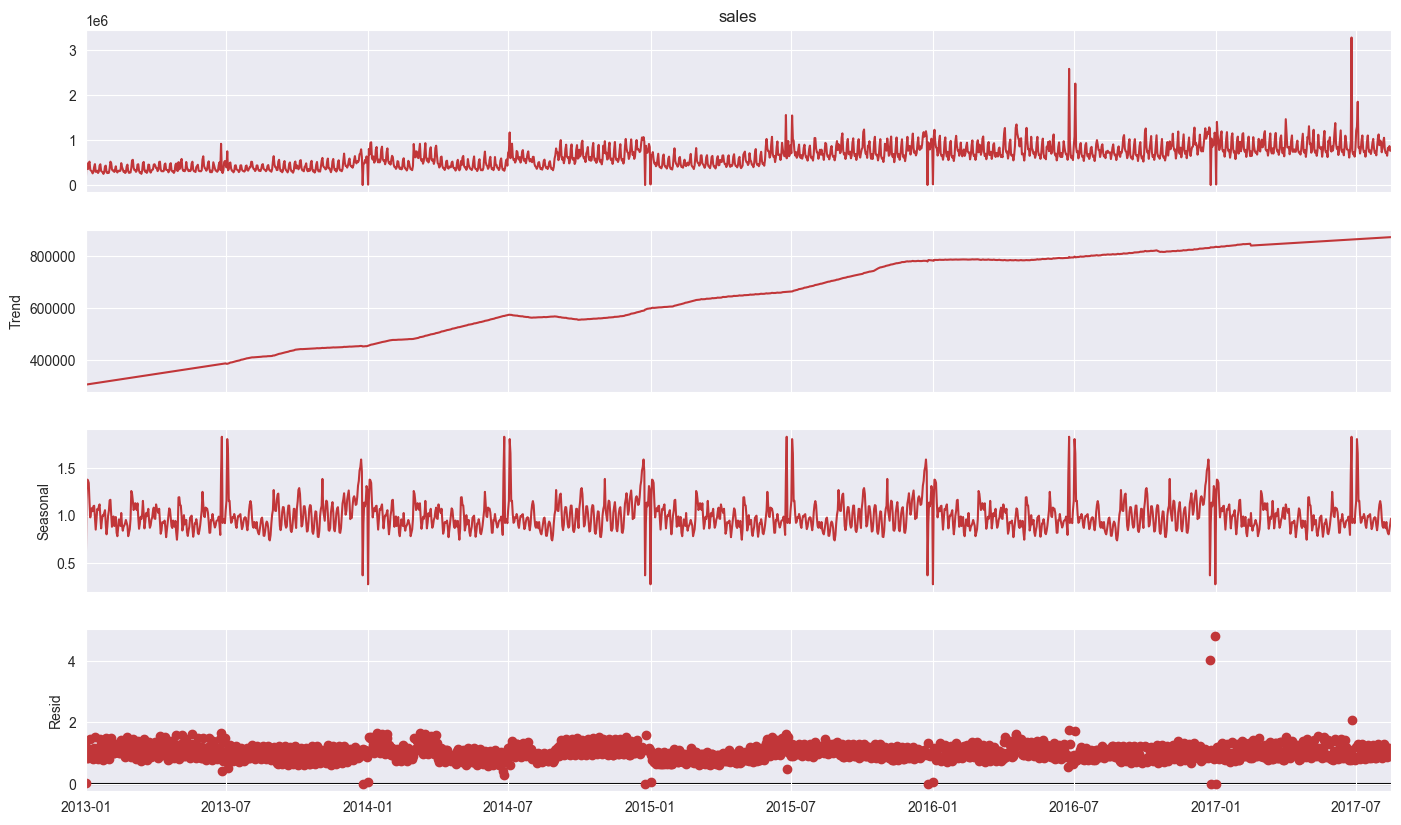

In [1684]:
fig = result.plot()
fig.set_size_inches((16, 9))

plt.show()

as we can see if there is trend the data and also seasonal in 365 periods. That means the data is not stationary. We need to make the data stationary

In [1685]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("reject the null hypothesis. Data is stationary")
    else:
        print("Data is non-stationary ")


In [1686]:
adf_test(sample_data["sales"])

ADF Statistics: -2.617469225951435
p- value: 0.0894402161902223
Data is non-stationary 


from decomposition and adf test we can see that the data is not stationary. If we want to Use ARIMA or SARIMAX we need to transform the data to stationary but wa can also use Sarimax for seasonal data

let transform the data to make it stationary with first differentiation

In [1687]:
adf_test(sample_data["sales"].diff().dropna())

ADF Statistics: -11.332244783811054
p- value: 1.1054233645487554e-20
reject the null hypothesis. Data is stationary


### Forecasting

In [1688]:
test_size = round(len(sample_data)*(0.25))
train_size = len(sample_data) - test_size

In [1689]:
train_data = sample_data.iloc[:train_size]
test_data = sample_data.iloc[train_size:]

#### ARIMA

we will start with the ARIMA model. before that we need to find the best parameter for the model especially for p and q. we will use the ACF and PACF plot to find the best parameter.

In [1690]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


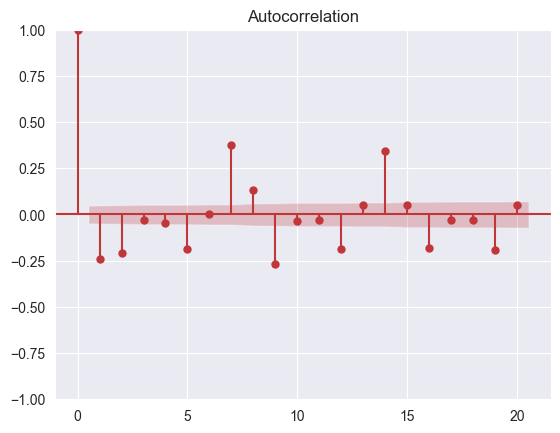

In [1691]:
plot_acf(sample_data["sales"].diff().dropna(), lags = 20)

plt.show()

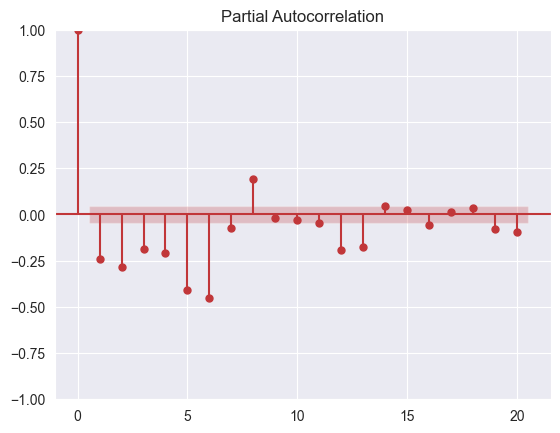

In [1692]:
plot_pacf(sample_data["sales"].diff().dropna(), lags = 20)

plt.show()

In [1693]:
import warnings
warnings.filterwarnings('ignore')

In [1694]:
import statsmodels.api as sm


In [1695]:
from sklearn.metrics import mean_squared_log_error   

In [1696]:
# p, d, q = 1,1,1 # paramters for ARIMA model

# model = sm.tsa.ARIMA(train_data['sales'], order=(p, d, q))
# results = model.fit()

# predictions = results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

# rmsle_score = rmsle(test_data['sales'], predictions)

# list_rmsle.append(rmsle_score)

# mse = mean_squared_error(test_data['sales'], predictions)
# print(f'Mean Squared Error: {mse}')
# print(f'RMSLE: {rmsle_score}')

# plt.plot(train_data.index, train_data['sales'], label='train_data')
# plt.plot(test_data.index, test_data['sales'], label='test_data')
# plt.plot(test_data.index, predictions, label='Predictions', linestyle='dashed', color = "green")
# plt.legend()
# plt.show()


#### SARIMAX

because the data is seasonal, lets try SARIMA model

In [1697]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

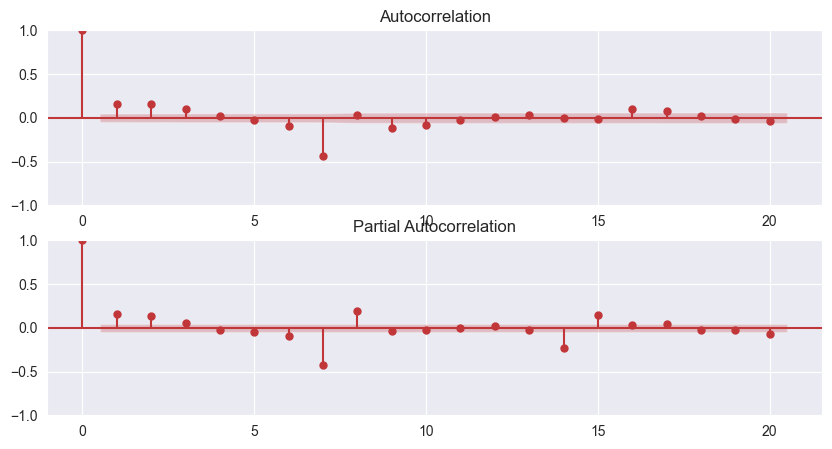

In [1698]:
fig, ax = plt.subplots(2, 1, figsize=(10,5))

plot_acf(sample_data["sales"].diff(7).dropna(), lags=20, ax=ax[0])

plot_pacf(sample_data["sales"].diff(7).dropna(), lags=20, ax=ax[1])

plt.show()


In [1699]:
# p, d, q = 1,0,1

# model = SARIMAX(train_data['sales'], order=(p, d, q), seasonal_order=(0, 1, 0,7))
# results = model.fit()

# predictions = results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

# rmsle_score = rmsle(test_data['sales'], predictions)

# list_rmsle.append(rmsle_score)

# mse = mean_squared_error(test_data['sales'], predictions)
# print(f'Mean Squared Error: {mse}')
# print(f'RMSLE: {rmsle_score}')

# plt.plot(train_data.index, train_data['sales'], label='train_data')
# plt.plot(test_data.index, test_data['sales'], label='test_data')
# plt.plot(test_data.index, predictions, label='Predictions', linestyle='dashed', color = "green")
# plt.legend()
# plt.show()


#### FB Prophet Model  

In [1700]:
from prophet import Prophet

In [1701]:
sample_prophet = all_train_group["sales"].reset_index().rename(columns={"date":"ds", "sales":"y"})

In [1702]:
X_train_prophet = sample_prophet.iloc[:train_size]
X_test_prophet = sample_prophet.iloc[train_size:]

##### First Model Prophet

In [1703]:
model = Prophet()
model.fit(X_train_prophet)

predictions = model.predict(X_test_prophet)
train_predictions = model.predict(X_train_prophet)

16:01:37 - cmdstanpy - INFO - Chain [1] start processing
16:01:38 - cmdstanpy - INFO - Chain [1] done processing


In [1704]:
def result_prophet(predictions, train_predictions):
    rmsle_test= rmsle(X_test_prophet['y'].reset_index(drop=True), predictions['yhat'].reset_index(drop = True))
    mse_test = mean_squared_error(X_test_prophet['y'], predictions['yhat'])
    rmse_test = np.sqrt(mse)

    rmsle_train = rmsle(X_train_prophet['y'], train_predictions['yhat'])
    mse_train = mean_squared_error(X_train_prophet['y'], train_predictions['yhat'])
    rmse_train = np.sqrt(mse_train)

    result = pd.DataFrame([[mse_train,mse_test], [rmse_train, rmse_test], [rmsle_train, rmsle_test]], columns=["train", "test"])
    pd.options.display.float_format = '{:,.2f}'.format
    return result  

In [1705]:
result_prophet(predictions, train_predictions)

train              test
0 14,108,554,196.25 64,117,877,845.62
1        118,779.44         66,139.08
2              0.59              0.64

##### Second Model Prophet

lets add some features

In [1706]:
holidays_prophet = holidays_events_filtered.reset_index().rename(columns={"date":"ds", "national":"holiday"})[['ds', 'holiday']]

In [1707]:
holidays_prophet = holidays_prophet[holidays_prophet["holiday"] == 1]
holidays_prophet["holiday"] = "national"


In [1708]:
model2 = Prophet(holidays=holidays_prophet)

model2.fit(X_train_prophet)
predictions2 = model2.predict(X_test_prophet)
train_predictions2 = model2.predict(X_train_prophet)

16:01:38 - cmdstanpy - INFO - Chain [1] start processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing


In [1709]:
result_prophet(predictions2, train_predictions2)

train              test
0 13,991,228,424.47 64,649,544,853.09
1        118,284.52         66,139.08
2              0.59              0.64

#### Third Model Prophet

In [1710]:
sample_data2 = all_train_group[["sales", "onpromotion", "dcoilwtico"]].reset_index().rename(columns={"date":"ds", "sales":"y"})

In [1711]:
X_train_prophet2 = sample_data2.iloc[:train_size]
X_test_prophet2 = sample_data2.iloc[train_size:]

In [1712]:
model3 = Prophet(holidays=holidays_prophet, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays_prior_scale=0.3, changepoint_prior_scale=0.1)

model3.add_regressor("onpromotion")
model3.add_regressor("dcoilwtico")

In [1713]:
model3.fit(X_train_prophet2)

predictions3 = model3.predict(X_test_prophet2)
train_predictions3 = model3.predict(X_train_prophet2)

16:01:40 - cmdstanpy - INFO - Chain [1] start processing
16:01:40 - cmdstanpy - INFO - Chain [1] done processing


In [1714]:
result_prophet(predictions3, train_predictions3)

train              test
0 10,307,216,271.16 30,548,503,461.85
1        101,524.46         66,139.08
2              0.55              0.59

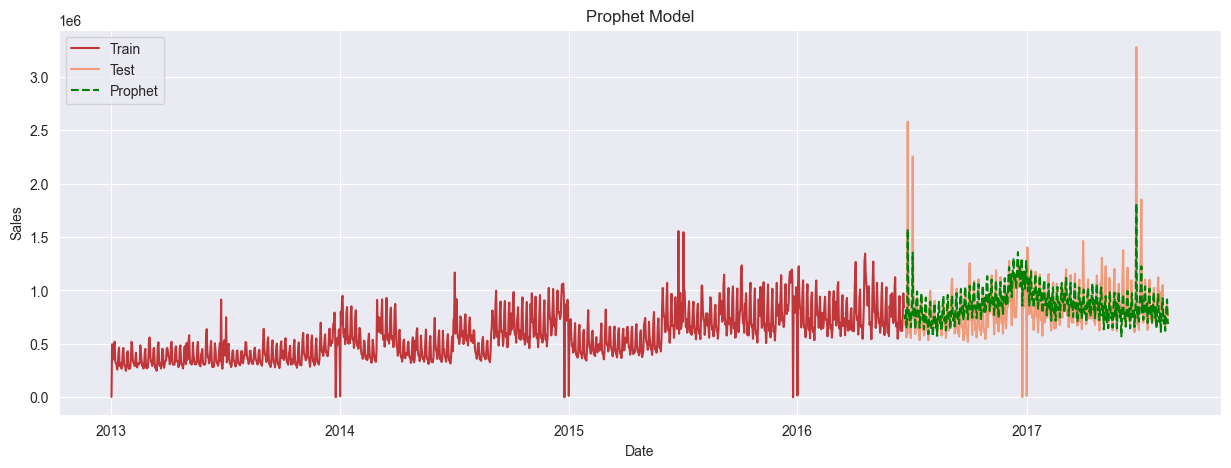

In [1716]:
plt.subplots(figsize=(15, 5))


plt.plot(X_train_prophet2["ds"], X_train_prophet2["y"], label="Train")
plt.plot(X_test_prophet2["ds"], X_test_prophet2["y"], label="Test")

plt.plot(X_test_prophet2["ds"], predictions3["yhat"], label="Prophet", color = "green", linestyle='dashed')

plt.title("Prophet Model")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.legend()

plt.show()

#### Machine Learning Model (XGBoost)

these features will be same for each date

In [1858]:
train_ml1 = df_train.drop(columns=["family", "city", "state", "type", "cluster", "store_nbr"]).copy()

In [1859]:
df_encoding = pd.get_dummies(data=train_ml1[["weekday"]])
train_ml1.drop(columns = "weekday", inplace =True)

In [1860]:
all_train = pd.concat([df_encoding, train_ml1], axis=0)
all_train_group = all_train.groupby(all_train.index).sum().reset_index()
all_train_group.set_index("date", inplace = True)

In [1861]:
# all_train_group["lag1"] = all_train_group["sales"].shift(7)
# all_train_group["lag14"] = all_train_group["sales"].shift(14)
# all_train_group["lag365"] = all_train_group["sales"].shift(365)

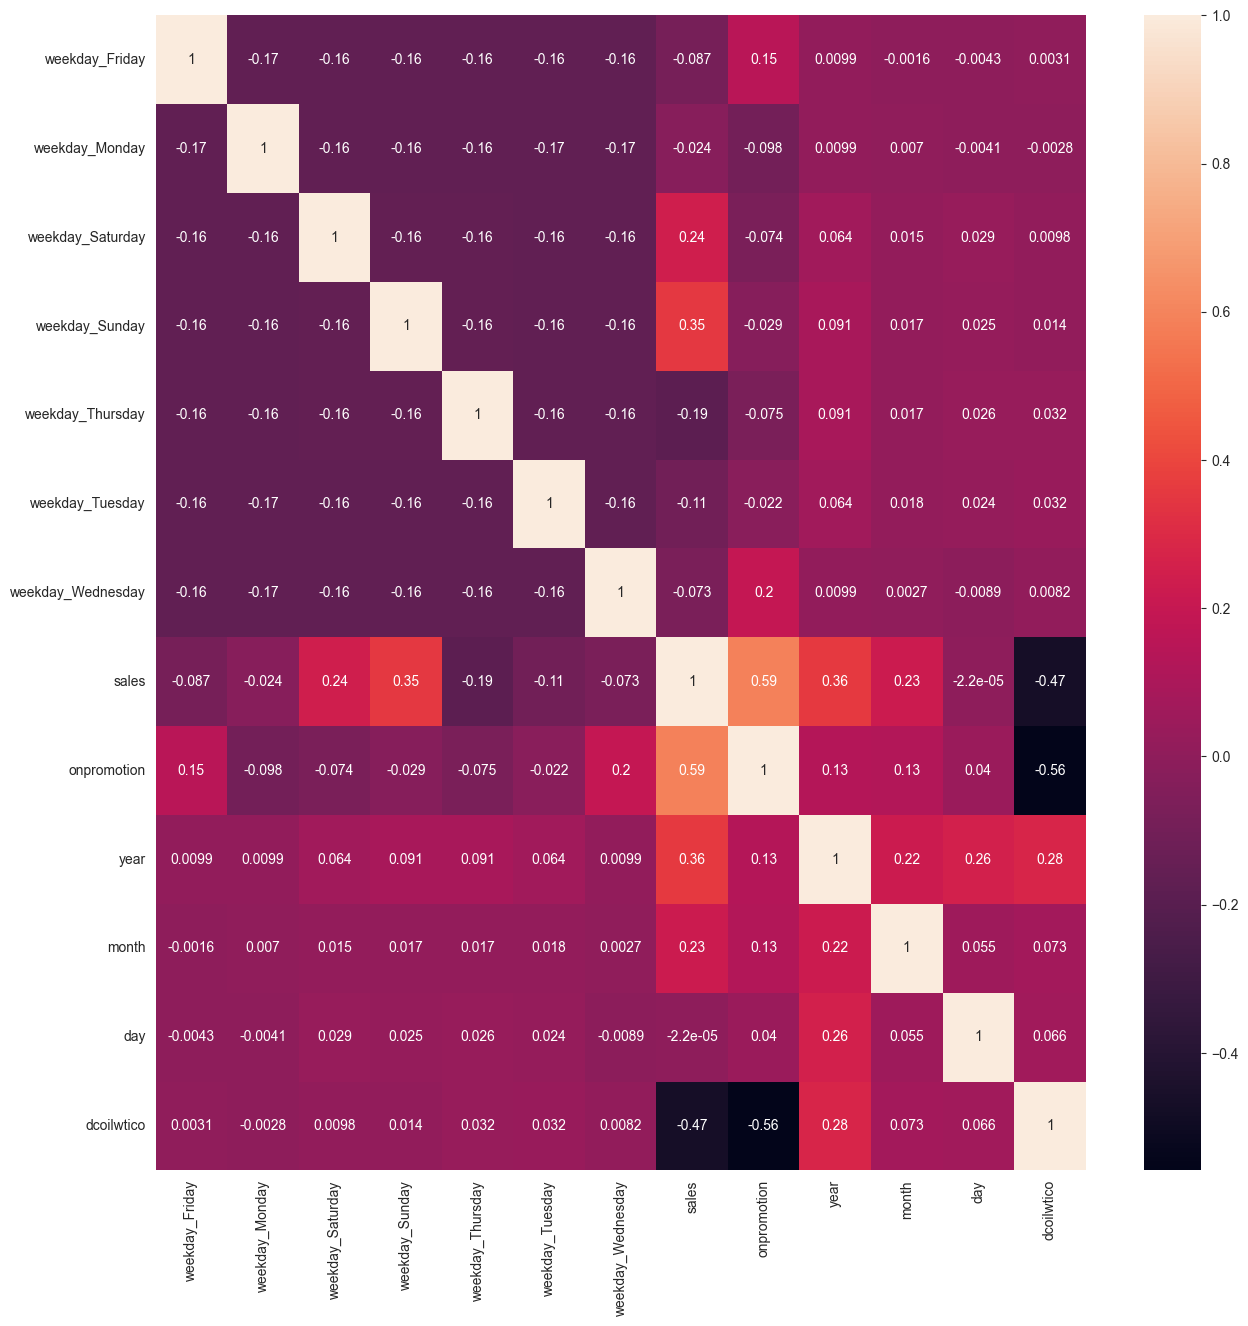

In [1862]:
plt.figure(figsize=(15,15))

sns.heatmap(all_train_group.corr(), annot=True)
plt.show()

In [1863]:
X = all_train_group.drop(columns = "sales")
y = all_train_group["sales"]

In [1864]:
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

In [1865]:
X_train.fillna(0, inplace=True)

##### XGBoost

In [1866]:
import xgboost as xgb

In [1867]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


predictions = reg.predict(X_test)
predictions_train = reg.predict(X_train)


[0]	validation_0-rmse:610498.31378	validation_1-rmse:869440.81509
[100]	validation_0-rmse:254656.39283	validation_1-rmse:433383.11249
[200]	validation_0-rmse:137575.84936	validation_1-rmse:267509.70247


[300]	validation_0-rmse:101690.52171	validation_1-rmse:208289.55203
[400]	validation_0-rmse:88296.80359	validation_1-rmse:183801.52217
[500]	validation_0-rmse:81792.70882	validation_1-rmse:170567.61060
[600]	validation_0-rmse:77417.34697	validation_1-rmse:163504.36021
[700]	validation_0-rmse:74191.67368	validation_1-rmse:158462.65966
[800]	validation_0-rmse:71704.65617	validation_1-rmse:153212.16469
[900]	validation_0-rmse:69558.10850	validation_1-rmse:149343.38881
[999]	validation_0-rmse:67403.28345	validation_1-rmse:146811.54020


In [1868]:
def result_ml(predictions, predictions_train):
    rmsle_test= rmsle(y_test, predictions)
    mse_test = mean_squared_error(y_test, predictions)
    rmse_test = np.sqrt(mse_test)

    rmsle_train = rmsle(y_train, predictions_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)

    result = pd.DataFrame([[mse_train,mse_test], [rmse_train, rmse_test], [rmsle_train, rmsle_test]], columns=["train", "test"], index=["MSE", "RMSE", "RMSLE"])
    pd.options.display.float_format = '{:,.2f}'.format
    return result 

In [1869]:
result_ml(predictions, predictions_train)

train              test
MSE   4,543,202,553.12 21,553,628,199.83
RMSE         67,403.28        146,811.54
RMSLE             0.40              0.40

##### Complete Data Train 

In [2538]:
train_ml = df_train.copy()
train_ml.fillna(0, inplace=True)

In [2539]:
#add anotherparamaeter based on the date

train_ml["dayofyear"] = train_ml.index.dayofyear
train_ml["weekofyear"] = train_ml.index.weekofyear
train_ml["quarter"] = train_ml.index.quarter

train_ml["is_month_start"] = train_ml.index.is_month_start
train_ml["is_month_end"] = train_ml.index.is_month_end
train_ml["is_quarter_start"] = train_ml.index.is_quarter_start
train_ml["is_mid_month"] = train_ml.index.is_month_end


In [2540]:
store = train_ml["store_nbr"].unique()
family = train_ml["family"].unique()

In [2541]:
train_ml.head(1)

id  store_nbr      family  sales  onpromotion  year  month  \
date                                                                     
2013-01-01   0          1  AUTOMOTIVE   0.00            0  2013      1   

            weekday  day   city  ... cluster dcoilwtico  national  dayofyear  \
date                             ...                                           
2013-01-01  Tuesday    1  Quito  ...      13      93.14         0          1   

            weekofyear  quarter  is_month_start  is_month_end  \
date                                                            
2013-01-01           1        1            True         False   

            is_quarter_start  is_mid_month  
date                                        
2013-01-01              True         False  

[1 rows x 22 columns]

In [2542]:
# i wann make stte as dict for label encoding

state_dict = dict(zip(train_ml["state"].unique(), range(len(train_ml["state"].unique()))))
city_dict = dict(zip(train_ml["city"].unique(), range(len(train_ml["city"].unique()))))
# type = dict(zip(train_ml["family"].unique(), range(len(train_ml["family"].unique()))))

train_ml["state"] = train_ml["state"].map(state_dict)
# train_ml["city"] = train_ml["city"].map(city_dict)
# train_ml["family"] = train_ml["family"].map(type)

train_ml_enc = pd.get_dummies(train_ml, columns=["weekday", "type", "city"])


In [2543]:
train_ml_enc.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month',
       'day', 'state', 'cluster', 'dcoilwtico', 'national', 'dayofyear',
       'weekofyear', 'quarter', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_mid_month', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'type_A', 'type_B', 'type_C',
       'type_D', 'type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe',
       'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas',
       'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga',
       'city_Libertad', 'city_Loja', 'city_Machala', 'city_Manta',
       'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo'],
      dtype='object')

In [2544]:
zero_sales

store_nbr                      family  sales  psr
1             1                   BABY CARE   0.00 0.00
166           6                   BABY CARE   0.00 0.00
268           9                       BOOKS   0.00 0.00
301          10                       BOOKS   0.00 0.00
334          11                       BOOKS   0.00 0.00
...         ...                         ...    ...  ...
1714         52  SCHOOL AND OFFICE SUPPLIES   0.00 0.00
1715         52                     SEAFOOD   0.00 0.00
1753         54                       BOOKS   0.00 0.00
1768         54                  LADIESWEAR   0.00 0.00
1769         54             LAWN AND GARDEN   0.00 0.00

[86 rows x 4 columns]

In [2545]:
train_ml_enc.drop(train_ml_enc[train_ml_enc["id"].isin(zero_sales.index)].index, inplace=True)


In [2546]:
# train_ml_enc["lag7"] = train_ml_enc["sales"].shift(7)

# train_ml_enc["lag14"] = train_ml_enc["sales"].shift(14)

# train_ml_enc["lag21"] = train_ml_enc["sales"].shift(21)

In [2547]:
## add rolling mean

# train_ml_enc["rolling_mean_7"] = train_ml_enc["sales"].rolling(window=7).mean()
# train_ml_enc["rolling_mean_14"] = train_ml_enc["sales"].rolling(window=14).mean()

In [2548]:
### add exponential weighted mean
# train_ml_enc["ewm_1"] = train_ml_enc["sales"].ewm(span=14).mean()
# train_ml_enc["ewm_7"] = train_ml_enc["sales"].ewm(span=7).mean()
# train_ml_enc["ewm_30"] = train_ml_enc["sales"].ewm(span=30).mean()
# train_ml_enc["ewm_90"] = train_ml_enc["sales"].ewm(span=90).mean()


In [2549]:
train_ml_enc["ewm_7"] = train_ml_enc.groupby("store_nbr")["sales"].transform(lambda x: x.ewm(span=7).mean())
train_ml_enc["ewm_14"] = train_ml_enc.groupby("store_nbr")["sales"].transform(lambda x: x.ewm(span=14).mean())
train_ml_enc["ewm_30"] = train_ml_enc.groupby("store_nbr")["sales"].transform(lambda x: x.ewm(span=30).mean())
train_ml_enc["ewm_365"] = train_ml_enc.groupby("store_nbr")["sales"].transform(lambda x: x.ewm(span=90).mean())

In [2550]:
import numpy as np
import pandas as pd
from numba import njit
import xgboost as xgb

## ... (rest of the code remains the same)

# Define RMSLE function with Numba acceleration
@njit
def numba_rmsle(y_true, y_pred):
    n = len(y_true)
    epsilon = 1e-10  # Small constant to avoid log(0)
    diff = np.log1p(y_pred + epsilon) - np.log1p(y_true + epsilon)
    diff_n = np.nan_to_num(diff)
    rmsle = np.sqrt(np.sum(diff_n ** 2) / n)
    return rmsle

# ... (rest of the code remains the same)


# ... (assuming you have the necessary imports and data loaded)

# Rest of the code remains the same

rmsle_tests = []
rmsle_trains = []
average_rmsle_per_family = {}

for m in family:
    df = train_ml_enc[train_ml_enc["family"] == m]
    X = df.drop(columns=["sales", "family"])
    y = df["sales"]

    # Skip if family has zero total sales
    # if y.sum() == 0:
    #     print(f"Skipped Family {m} due to zero total sales.")
    #     continue

    X_train = X.loc[:'2016-06-19']
    y_train = y.loc[:'2016-06-19']

    X_test = X.loc['2016-06-20':]
    y_test = y.loc['2016-06-20':]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False)

    predictions = reg.predict(X_test)
    predictions_train = reg.predict(X_train)
    rmsle_test = numba_rmsle(y_test.values, predictions)
    rmsle_tests.append(rmsle_test)
    rmsle_train = numba_rmsle(y_train.values, predictions_train)
    rmsle_trains.append(rmsle_train)

    # Store RMSLE for each family
    average_rmsle_per_family.setdefault(m, []).append(rmsle_test)
    average_rmsle_per_family.setdefault(m, []).append(rmsle_train)

    # Print progress and RMSLE for each family
    print(f"Processed Family {m}: RMSLE Test = {rmsle_test:.4f}, RMSLE Train = {rmsle_train:.4f}")
    

# Calculate and print the average RMSLE for each family
for m, rmsle_list in average_rmsle_per_family.items():
    avg_rmsle_test = np.mean(rmsle_list[::2])  # Average every second element for test set
    avg_rmsle_train = np.mean(rmsle_list[1::2])  # Average every second element for train set
    print(f"Average RMSLE for Family {m}: Test = {avg_rmsle_test:.4f}, Train = {avg_rmsle_train:.4f}")

print(f"\nOverall Average RMSLE for Test: {np.mean(rmsle_tests):.4f}")
print(f"Overall Average RMSLE for Train: {np.mean(rmsle_trains):.4f}")


Processed Family AUTOMOTIVE: RMSLE Test = 0.6071, RMSLE Train = 0.5937
Processed Family BABY CARE: RMSLE Test = 0.3525, RMSLE Train = 0.1800
Processed Family BEAUTY: RMSLE Test = 0.5447, RMSLE Train = 0.5222
Processed Family BEVERAGES: RMSLE Test = 0.4009, RMSLE Train = 0.9578
Processed Family BOOKS: RMSLE Test = 0.4041, RMSLE Train = 0.2484
Processed Family BREAD/BAKERY: RMSLE Test = 0.4959, RMSLE Train = 0.8605
Processed Family CELEBRATION: RMSLE Test = 0.7238, RMSLE Train = 0.8648
Processed Family CLEANING: RMSLE Test = 0.2498, RMSLE Train = 0.9889
Processed Family DAIRY: RMSLE Test = 0.4336, RMSLE Train = 0.8419
Processed Family DELI: RMSLE Test = 0.2493, RMSLE Train = 0.7093
Processed Family EGGS: RMSLE Test = 0.4904, RMSLE Train = 0.6582
Processed Family FROZEN FOODS: RMSLE Test = 0.4873, RMSLE Train = 0.7227
Processed Family GROCERY I: RMSLE Test = 0.5613, RMSLE Train = 1.1632
Processed Family GROCERY II: RMSLE Test = 0.7666, RMSLE Train = 0.7499
Processed Family HARDWARE: RMSLE

In [2551]:
# can you make the same code above using lightGBM

import lightgbm as lgb

@njit
def numba_rmsle(y_true, y_pred):
    n = len(y_true)
    epsilon = 1e-10  # Small constant to avoid log(0)
    diff = np.log1p(y_pred + epsilon) - np.log1p(y_true + epsilon)
    diff_n = np.nan_to_num(diff)
    rmsle = np.sqrt(np.sum(diff_n ** 2) / n)
    return rmsle

rmsle_tests = []
rmsle_trains = []
average_rmsle_per_family = {}

for m in family:
    df = train_ml_enc[train_ml_enc["family"] == m]
    X = df.drop(columns=["sales", "family"])
    y = df["sales"]

    # Skip if family has zero total sales
    # if y.sum() == 0:
    #     print(f"Skipped Family {m} due to zero total sales.")
    #     continue

    X_train = X.loc[:'2016-06-19']
    y_train = y.loc[:'2016-06-19']

    X_test = X.loc['2016-06-20':]
    y_test = y.loc['2016-06-20':]

    reg = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)])

    predictions = reg.predict(X_test)
    predictions_train = reg.predict(X_train)
    rmsle_test = numba_rmsle(y_test.values, predictions)
    rmsle_tests.append(rmsle_test)
    rmsle_train = numba_rmsle(y_train.values, predictions_train)
    rmsle_trains.append(rmsle_train)

    # Store RMSLE for each family
    average_rmsle_per_family.setdefault(m, []).append(rmsle_test)
    average_rmsle_per_family.setdefault(m, []).append(rmsle_train)

    # Print progress and RMSLE for each family
    print(f"Processed Family {m}: RMSLE Test = {rmsle_test:.4f}, RMSLE Train = {rmsle_train:.4f}")

# Calculate and print the average RMSLE for each family
for m, rmsle_list in average_rmsle_per_family.items():
    avg_rmsle_test = np.mean(rmsle_list[::2])  # Average every second element for test set
    avg_rmsle_train = np.mean(rmsle_list[1::2])  # Average every second element for train set
    print(f"Average RMSLE for Family {m}: Test = {avg_rmsle_test:.4f}, Train = {avg_rmsle_train:.4f}")

print(f"\nOverall Average RMSLE for Test: {np.mean(rmsle_tests):.4f}")
print(f"Overall Average RMSLE for Train: {np.mean(rmsle_trains):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 68148, number of used features: 54
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 5.794829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Processed Family AUTOMOTIVE: RMSLE Test = 0.6013, RMSLE Train = 0.5939
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

In [2497]:
numba_rmsle(y_test.values, predictions)

0.6787462327613244

In [2357]:
numba_rmsle(y_train.values, predictions_train)

0.8961237712211898

In [2358]:
np.log1p(y_train.values)

array([3.66430496, 1.38629436, 1.79175947, ..., 3.50486647, 3.98863213,
       3.37238627])

In [2359]:
np.log1p(predictions_train)

array([3.3684814, 2.1075227, 1.5366015, ..., 4.176612 , 4.176612 ,
       3.2819896], dtype=float32)

In [2360]:
check = np.sqrt((np.log1p(y_train.values+epsilon) - np.log1p(predictions_train+epsilon))**2)

In [2361]:
#chekck nan in check
#how to fill nan in check

check = 

SyntaxError: invalid syntax (4002468721.py, line 4)

In [ ]:
np.sqrt(np.log1p(y_train.values)-np.log1p(predictions))

ValueError: operands could not be broadcast together with shapes (68202,) (22734,) 

In [ ]:
y_train

date
2013-01-01    0.00
2013-01-01    0.00
2013-01-01    0.00
2013-01-01    0.00
2013-01-01    0.00
              ... 
2016-06-19    7.00
2016-06-19    6.00
2016-06-19    3.00
2016-06-19    3.00
2016-06-19   13.00
Name: sales, Length: 68202, dtype: float64

In [ ]:
predictions_train

array([ 1.5712528,  1.7734703,  3.962538 , ...,  7.433613 ,  7.480073 ,
       15.329245 ], dtype=float32)

In [ ]:
train_ml.drop(columns = ["id"], inplace = True)

In [ ]:
train_ml_enc["lag1"] = train_ml_enc["sales"].shift(7)

In [ ]:
train_size = round(len(all_train_group)*(0.75))

X_train = all_train_group.iloc[:train_size].drop(columns="sales")
X_train.index.max()

Timestamp('2016-06-19 00:00:00')

In [ ]:
X = train_ml_enc.drop(columns = "sales")
y = train_ml_enc["sales"]

X_train = X.loc[:'2016-06-19']
y_train = y.loc[:'2016-06-19']

X_test = X.loc['2016-06-20':]
y_test = y.loc['2016-06-20':]


In [ ]:
X_test.shape, X_train.shape

((750222, 54), (2250666, 54))

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=5,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


predictions = reg.predict(X_test)
predictions_train = reg.predict(X_train)


[0]	validation_0-rmse:1058.08160	validation_1-rmse:1394.91895
[100]	validation_0-rmse:693.81019	validation_1-rmse:937.59365
[200]	validation_0-rmse:596.80668	validation_1-rmse:775.27077
[300]	validation_0-rmse:544.78585	validation_1-rmse:691.49193
[400]	validation_0-rmse:511.82704	validation_1-rmse:640.09924
[499]	validation_0-rmse:491.08460	validation_1-rmse:609.40067


In [2183]:
result_ml(predictions, predictions_train)

train       test
MSE   241,164.09 371,369.18
RMSE      491.08     609.40
RMSLE       2.92       2.39

In [ ]:
RMS

### Summary Forecasting

Based on some models that we have tried some experiment, we can see that the best model is Machine Learning with the XGBoost model. It has the lowest RMSLE test and train. The next step is to use the XGBoost model to forecast the sales for the next 16 days.

## Submission

In [2035]:
test_submit = test.copy()

In [2036]:
test_submit.drop(columns = ["id", "store_nbr", "family"], inplace=True)

In [2037]:
test_submit = test_submit.groupby(test_submit.index).sum()

In [2038]:
test_submit["year"] = test_submit.index.year
test_submit["month"] = test_submit.index.month
test_submit["day"] = test_submit.index.day
test_submit["weekday"] = test_submit.index.weekday
test_submit["weekday"] = test_submit["weekday"].map({i: j for i, j in enumerate(weekday_order)})


In [2039]:
test_submit = pd.get_dummies(data=test_submit, columns=["weekday"])


In [2040]:
holidays_events_filtered_test = holidays_events_filtered[holidays_events_filtered.index.isin(test_submit.index)]

In [2041]:
df_test_submit = (test_submit
            .merge(oil[["dcoilwtico"]], left_index=True, right_index=True, how="left").set_index(test_submit.index)
            .merge(holidays_events_filtered_test[["national"]], left_index=True, right_index=True, how="left")
           )

In [2043]:
df_test_submit.fillna(0, inplace=True)

In [2052]:
X = df_test_submit[X_train.columns]

In [2054]:
X.columns

Index(['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'onpromotion', 'year', 'month', 'day',
       'dcoilwtico'],
      dtype='object')

In [2050]:
X_train.columns

Index(['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'onpromotion', 'year', 'month', 'day',
       'dcoilwtico'],
      dtype='object')

In [2048]:
df_test_submit["national"] = df_test_submit["national"].astype(int)

In [2055]:
reg.predict(X)

array([402168.44, 399241.2 , 402168.44, 399241.2 , 399778.84, 399241.2 ,
       399778.84, 402168.44, 399241.2 , 402168.44, 399778.84, 399778.84,
       399241.2 , 400734.4 , 402168.44, 402168.44], dtype=float32)

In [2057]:
submission.shape

NameError: name 'submission' is not defined

In [2061]:
!pwd

/Users/akmal/Documents/personal/projects/store-sales


In [2062]:
sample_submission = pd.read_csv("dataset/sample_submission.csv")
sample_submission.shape

(28512, 2)

In [2063]:
test.shape

(28512, 4)